# **Feature extraction** 

### Dependencies

In [78]:
import pandas as pd
from pathlib import Path
import numpy as np
import time
import os
import statsmodels
import seaborn as sns
import matplotlib.pyplot as plt
import glob
from scipy import stats
import pingouin as pg
#import scikit_posthocs as sp
import scipy as sp
import statsmodels.api as sm
from scipy.stats import boxcox
from statannotations.Annotator import Annotator
from scipy.stats import pearsonr
from sklearn.preprocessing import normalize
import statsmodels.formula.api as smf
from functools import reduce
from scipy.stats import shapiro
from scipy.special import logit, expit


#### Date 

In [79]:
date="2025_04_15"

### Load dasets 

In [80]:
lat_df_gamma = pd.read_csv("../../Datasets/eeg/whole_brain_datasets/lateralization_power/2025_whole_brain_latpwr_gamma.csv") 
frontal_power_6 = pd.read_csv("../../Datasets/eeg/region_specific_datasets/frontal_power/eegip_6_frontal_multitaper_09_03_2024.csv")
lat_df_region = pd.read_csv("../../Datasets/eeg/region_specific_datasets/lateralization_power/2025_region_latpwr_gamma.csv")  
con_df_gamma = pd.read_csv("../../Datasets/eeg/whole_brain_datasets/connectivity/2024_whole_brain_con_gamma.csv")  
con_df_region_theta = pd.read_csv("../../Datasets/eeg/region_specific_datasets/connectivity/2024_region_con_theta.csv")
con_df_region_gamma = pd.read_csv("../../Datasets/eeg/region_specific_datasets/connectivity/2024_region_con_gamma.csv")
con_df_region_alpha = pd.read_csv("../../Datasets/eeg/region_specific_datasets/connectivity/2024_region_con_alpha.csv")
frontal_power_6_sources= pd.read_csv("../../Datasets/eeg/region_specific_datasets/frontal_power/sources_power_6mo_april_2025.csv")
 
behv_df = pd.read_csv("../../Datasets/behaviour/language_datasets/source/EEGIP_msel_20210510.csv")   
asd_df = pd.read_csv("../../Datasets/behaviour/demographics/demographics_eegip_2024.csv")  
demo_df = pd.read_csv("../../Datasets/behaviour/demographics/source/mastersheet_latest.csv")  

## Clean up the demograhics dataset

In [81]:
demo_df=demo_df.rename(columns = {'ID':'subject','Risk Group':'group_type', 'Site':'site', 'High-risk Outcome':'alternative_outcome'}) #Sutbset by important columns
demo_df=demo_df[['subject','site',"group_type", "outcome","sex","alternative_outcome"]]
demo_df['group_type'] = demo_df['group_type'].replace({'High Risk': 'ELA', 'Low Risk': 'TLA'}) # Convert High Risk to HRA and Low Risk to LRC
demo_df['subject'] = demo_df['subject'].replace({'EC': ''}, regex=True) 
demo_df["site"] = demo_df["site"].str.lower() # Convert site to lowercase
demo_df = demo_df.replace({'777': np.nan}, regex=True) # Code 777 means missing data so replace with NaN
demo_df = demo_df.replace({777: np.nan}, regex=True) # Code 777 means missing data so replace with NaN
demo_df['alternative_outcome'] = demo_df['alternative_outcome'].replace({3: 'asd',2:'no-asd', 0:'no-asd', 1:'no-asd'}, regex=True) 
demo_df['outcome'] = demo_df['outcome'].fillna(demo_df['alternative_outcome']) # Fill missing outcome with alternative outcome
demo_df = demo_df.drop(columns=['alternative_outcome']) # Drop alternative outcome
demo_df

,subject,site,group_type,outcome,sex
0,601,london,ELA,asd,F
1,602,london,ELA,NaN,F
2,603,london,ELA,no-asd,M
3,604,london,ELA,no-asd,M
4,605,london,ELA,asd,M
...,...,...,...,...,...
187,164,washington,TLA,no-asd,M
188,166,washington,TLA,no-asd,M
189,915,washington,TLA,no-asd,M
190,933,washington,TLA,asd,M


In [82]:
demo_df[['site', 'group_type', 'outcome','sex']].value_counts()

site        group_type  outcome  sex
london      TLA         no-asd   F      29
            ELA         no-asd   F      26
washington  ELA         no-asd   M      23
london      TLA         no-asd   M      21
washington  TLA         no-asd   M      21
                                 F      16
london      ELA         asd      M      11
                        no-asd   M      10
washington  ELA         asd      F       7
london      ELA         asd      F       6
washington  ELA         no-asd   F       6
                        asd      M       5
            TLA         asd      M       2
                                 F       1
dtype: int64

In [83]:
# Sanity check for unique values
for column in demo_df.columns:
    print(column, demo_df[column].unique()) # Check unique values in each column

subject ['601' '602' '603' '604' '605' '606' '607' '608' '609' '610' '611' '612'
 '613' '614' '615' '616' '617' '618' '619' '620' '621' '622' '623' '624'
 '625' '626' '627' '628' '629' '630' '631' '632' '633' '634' '635' '636'
 '637' '638' '639' '640' '641' '642' '643' '644' '645' '646' '647' '648'
 '649' '650' '651' '652' '653' '654' '701' '702' '703' '704' '705' '706'
 '707' '708' '709' '710' '711' '712' '713' '714' '715' '716' '717' '718'
 '719' '720' '721' '722' '723' '724' '725' '726' '727' '728' '729' '730'
 '731' '732' '733' '734' '735' '736' '737' '738' '739' '740' '741' '742'
 '743' '744' '745' '746' '747' '748' '749' '750' '002' '003' '005' '006'
 '008' '009' '010' '016' '020' '022' '023' '024' '027' '028' '029' '030'
 '035' '042' '044' '045' '047' '048' '050' '051' '053' '054' '057' '058'
 '059' '060' '062' '063' '065' '067' '069' '070' '078' '085' '097' '098'
 '099' '101' '102' '105' '106' '107' '108' '110' '111' '113' '114' '115'
 '116' '118' '119' '120' '121' '122' '124' 

In [84]:
demo_df.to_csv("../../Datasets/behaviour/demographics/demographics_eegip_2024.csv", index=False) # Save the updated demographics file

### Functions

In [85]:
# Create function that removes outliers from a dataframe and plots the histograms before and after removing outliers
def plot_and_remove_outliers(df, column, z_threshold=3, transform=False, connectivity=False, sources=False, omitnans=False):
    
    # Check if the DataFrame is empty
    if len(df) == 0:
        return "DataFrame is empty, no data to process."
    
    fig, axs = plt.subplots(1, 2, figsize=(15, 5))

    # Flag if transformation is needed
    if shapiro(df[column])[1] < 0.05:
        print("$Data is not normal$")
        transform = True

    print("Shapiro normality test before: ", shapiro(df[column]))
    
    # Shapiro-Wilk normality test before removing outliers
    print("Number of participants before:", len(df))
     # Histogram before removing outliers
    sns.histplot(df[column], kde=True, ax=axs[0])
    axs[0].set_title("Before transforming")
    if transform and sources:
        print("No transformation needed for sources")
        transform = False
    if transform and not connectivity:
        df[column] = np.log(df[column])

    if transform and connectivity:
        # Do special logit transformation for connectivity data
        df[column] = logit(df[column])
    

    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    df_filtered = df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]
    print("Number of participants before:", len(df_filtered))

    # Histogram after removing outliers
    sns.histplot(df_filtered[column], kde=True, ax=axs[1])
    axs[1].set_title("After transforming and removing outliers")
    
    plt.show()

    # Check if data is normal after removing outliers
    if shapiro(df_filtered[column])[1] < 0.05:
        print("****Data still not normal****")
        transform = True
    
    return df_filtered

## EEG Measures based on literature

## Connectivity measures

In [86]:
# Create a dictionary with all possible combinations of frontal regions with central regions and frontal regions with ocipital regions

short_range_pairs={  
 'parsopercularis-insula-lh': ('parsopercularis-lh',
'insula-lh'),
 'parstriangularis-insula-lh': ('parstriangularis-lh',
  'insula-lh'),
  'parsorbitalis-insula-lh': ('parsorbitalis-lh',
  'insula-lh'),
 'rostralmiddlefrontal-lh_precentral-lh': ('rostralmiddlefrontal-lh',
  'precentral-lh'),
 'rostralmiddlefrontal-lh_postcentral-lh': ('rostralmiddlefrontal-lh',
  'postcentral-lh'),
   'lateralorbitofrontal-lh_insula-lh': ('lateralorbitofrontal-lh',
  'insula-lh')}
long_range_pairs = {'parsopercularis-lh_cuneus-lh': ('parsopercularis-lh', 'cuneus-lh'),
 'parsopercularis-lh_lingual-lh': ('parsopercularis-lh', 'lingual-lh'),
 'parsopercularis-lh_lateraloccipital-lh': ('parsopercularis-lh',
  'lateraloccipital-lh'),
 'parstriangularis-lh_cuneus-lh': ('parstriangularis-lh', 'cuneus-lh'),
 'parstriangularis-lh_lingual-lh': ('parstriangularis-lh', 'lingual-lh'),
 'parstriangularis-lh_lateraloccipital-lh': ('parstriangularis-lh',
  'lateraloccipital-lh'),
  'parsorbitalis-lh_cuneus-lh': ('parsorbitalis-lh', 'cuneus-lh'),
 'parsorbitalis-lh_lingual-lh': ('parsorbitalis-lh', 'lingual-lh'),
 'parsorbitalis-lh_lateraloccipital-lh': ('parsorbitalis-lh',
  'lateraloccipital-lh'),
  'rostralmiddlefrontal-lh_cuneus-lh': ('rostralmiddlefrontal-lh', 'cuneus-lh'),
 'rostralmiddlefrontal-lh_lingual-lh': ('rostralmiddlefrontal-lh',
  'lingual-lh'),
 'rostralmiddlefrontal-lh_lateraloccipital-lh': ('rostralmiddlefrontal-lh',
  'lateraloccipital-lh'),
 'rostralmiddlefrontal-lh_pericalcarine-lh': ('rostralmiddlefrontal-lh',
  'pericalcarine-lh'),
 'lateralorbitofrontal-lh_cuneus-lh': ('lateralorbitofrontal-lh', 'cuneus-lh'),
 'lateralorbitofrontal-lh_lateraloccipital-lh': ('lateralorbitofrontal-lh',
  'lateraloccipital-lh')}

frontal_regions = ['parsopercularis-lh','parstriangularis-lh', 'parsorbitalis-lh','rostralmiddlefrontal-lh',
                              'lateralorbitofrontal-lh', 'rostralmiddlefrontal-lh','caudalmiddlefrontal-lh', "frontalpole-lh"]
central_regions = ['precentral-lh',"postcentral-lh",'superiortemporal-lh','insula-lh']
occipital_regions = ['cuneus-lh','lingual-lh','lateraloccipital-lh','pericalcarine-lh'] 


#### **Measure** #1: Frontal gamma power PSD at 6 months

##### Get electrode space psd

In [87]:
front_gamma_power_6=frontal_power_6[["subject","gamma_multitaper"]]
front_gamma_power_6.rename(columns={"gamma_multitaper":"front_gamma_6"}, inplace=True)
front_gamma_power_6

C:\Users\gabot\AppData\Local\Temp\ipykernel_18548\2669741381.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  front_gamma_power_6.rename(columns={"gamma_multitaper":"front_gamma_6"}, inplace=True)


,subject,front_gamma_6
0,2,-9.997275
1,3,-10.166818
2,5,-10.711044
3,6,-10.385926
4,8,-10.270130
...,...,...
115,747,-9.531777
116,748,-9.893445
117,915,-9.951859
118,933,-9.952183


##### Get source space psd

In [88]:
frontal_power_6_sources["source_psd"]= (frontal_power_6_sources["left_psd"]+ frontal_power_6_sources["right_psd"])/2
frontal_power_6_sources

,subject,region1,left_psd,right_psd,source_psd
0,612,bankssts-rh,-20.572378,-20.649533,-20.610955
1,612,caudalanteriorcingulate-rh,-20.761276,-20.684378,-20.722827
2,612,caudalmiddlefrontal-rh,-20.895914,-21.000640,-20.948277
3,612,cuneus-rh,-21.103024,-21.212594,-21.157809
4,612,frontalpole-rh,-20.446853,-20.532972,-20.489912
...,...,...,...,...,...
4747,937,superiorparietal-rh,-21.420918,-21.483958,-21.452438
4748,937,superiortemporal-rh,-20.572139,-21.657236,-21.114687
4749,937,supramarginal-rh,-20.759800,-21.287791,-21.023796
4750,937,temporalpole-rh,-20.452834,-20.864788,-20.658811


##### Find source regions most related to electrode space

r:  0.6628071212056277 pval:  1.6356237655182243e-16


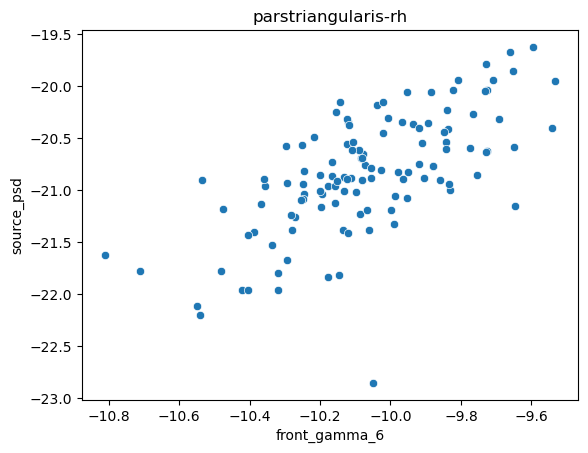

r:  0.6628071212056277 pval:  1.6356237655182243e-16
r:  0.6945032902359618 pval:  1.4076361661602112e-18


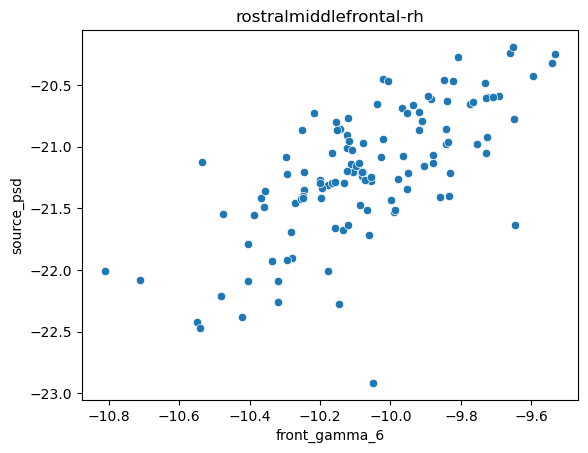

r:  0.6945032902359618 pval:  1.4076361661602112e-18
r:  0.6967973122227169 pval:  9.741708810590616e-19


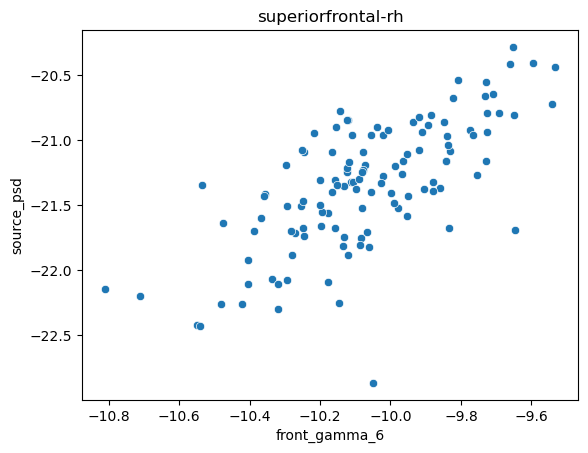

r:  0.6967973122227169 pval:  9.741708810590616e-19


,region,r,pval
27,superiorfrontal-rh,0.696797,9.741709e-19
26,rostralmiddlefrontal-rh,0.694503,1.407636e-18
19,parstriangularis-rh,0.662807,1.635624e-16
1,caudalanteriorcingulate-rh,0.644714,1.923949e-15
13,medialorbitofrontal-rh,0.640098,3.515251e-15


In [89]:
# Merge both and test
frontal_power_selection= pd.merge(front_gamma_power_6, frontal_power_6_sources[["subject","source_psd", "region1"]], on="subject", how="left")
frontal_power_selection

# For each region, check which source_psd correlates the most to front_gamma_6

electrode_region_correlations= []
for region in frontal_power_selection["region1"].unique():
    region_df= frontal_power_selection.loc[frontal_power_selection["region1"]==region]
    r, pval=pearsonr(region_df["front_gamma_6"], region_df["source_psd"])
    electrode_region_correlations.append([region, r, pval])
    if r > 0.65:
        print("r: ", r, "pval: ", pval)
        sns.scatterplot(data=region_df, x="front_gamma_6", y="source_psd")
        plt.title(region)
        plt.show()
        print("r: ", r, "pval: ", pval)

# Select the top 5 regions based on r 
electrode_region_correlations= pd.DataFrame(electrode_region_correlations, columns=["region", "r", "pval"])
electrode_region_correlations= electrode_region_correlations.sort_values(by="r", ascending=False)
electrode_region_correlations.head(5)



In [90]:
# Select how many regions provide the highest r value (Top 3 or 4 or 5)

results_r_values=[]
for number_rois in [1,2,3,4,5]:
    frontal_power_6_sources_post= frontal_power_selection.loc[frontal_power_selection["region1"].isin(electrode_region_correlations.head(number_rois)["region"])].groupby(["subject"]).mean().reset_index()
    

    r, pval=pearsonr(frontal_power_6_sources_post["front_gamma_6"], frontal_power_6_sources_post["source_psd"])
    results_r_values.append([number_rois, r, pval])
# Select the top 5 regions based on r 
results_r_values= pd.DataFrame(results_r_values, columns=["number_rois", "r", "pval"])
results_r_values= results_r_values.sort_values(by="r", ascending=False)
results_r_values.head(5)

C:\Users\gabot\AppData\Local\Temp\ipykernel_18548\4216378504.py:5: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  frontal_power_6_sources_post= frontal_power_selection.loc[frontal_power_selection["region1"].isin(electrode_region_correlations.head(number_rois)["region"])].groupby(["subject"]).mean().reset_index()
C:\Users\gabot\AppData\Local\Temp\ipykernel_18548\4216378504.py:5: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  frontal_power_6_sources_post= frontal_power_selection.loc[frontal_power_selection["region1"].isin(electrode_region_correlations.head(number_rois)["region"])].groupby(["subject"]).mean().re

,number_rois,r,pval
1,2,0.703841,3.077833e-19
0,1,0.696797,9.741709e-19
2,3,0.694474,1.414190e-18
3,4,0.685453,5.818657e-18
4,5,0.679933,1.348748e-17


In [91]:
frontal_power_6_sources

,subject,region1,left_psd,right_psd,source_psd
0,612,bankssts-rh,-20.572378,-20.649533,-20.610955
1,612,caudalanteriorcingulate-rh,-20.761276,-20.684378,-20.722827
2,612,caudalmiddlefrontal-rh,-20.895914,-21.000640,-20.948277
3,612,cuneus-rh,-21.103024,-21.212594,-21.157809
4,612,frontalpole-rh,-20.446853,-20.532972,-20.489912
...,...,...,...,...,...
4747,937,superiorparietal-rh,-21.420918,-21.483958,-21.452438
4748,937,superiortemporal-rh,-20.572139,-21.657236,-21.114687
4749,937,supramarginal-rh,-20.759800,-21.287791,-21.023796
4750,937,temporalpole-rh,-20.452834,-20.864788,-20.658811


In [92]:
# Based on this we must select the top 2 regions which includes the "Superior frontal gyrus" and the "Rostral middle frontal Gyrus"

frontal_power_6_sources= frontal_power_6_sources.loc[frontal_power_6_sources["region1"].isin(["rostralmiddlefrontal-rh","superiorfrontal-rh"])].groupby(["subject"]).mean().reset_index()

# Rename sources_psd to front_gamma_6
frontal_power_6_sources.rename(columns={"source_psd":"front_gamma_6"}, inplace=True)
frontal_power_6_sources

C:\Users\gabot\AppData\Local\Temp\ipykernel_18548\354650491.py:3: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  frontal_power_6_sources= frontal_power_6_sources.loc[frontal_power_6_sources["region1"].isin(["rostralmiddlefrontal-rh","superiorfrontal-rh"])].groupby(["subject"]).mean().reset_index()


,subject,left_psd,right_psd,front_gamma_6
0,2,-21.338468,-21.501764,-21.420116
1,3,-20.978246,-21.166934,-21.072590
2,5,-22.183740,-22.099607,-22.141673
3,6,-21.704755,-21.555984,-21.630370
4,8,-21.623194,-21.553045,-21.588120
...,...,...,...,...
139,747,-20.341699,-20.347224,-20.344462
140,748,-20.715175,-20.756124,-20.735650
141,915,-20.933006,-20.905038,-20.919022
142,933,-21.441719,-21.485055,-21.463387


In [93]:
frontal_power_6_sources= frontal_power_6_sources[["subject","front_gamma_6"]]

$Data is not normal$
Shapiro normality test before:  ShapiroResult(statistic=0.9698591232299805, pvalue=0.002894327277317643)
Number of participants before: 144
No transformation needed for sources
Number of participants before: 142


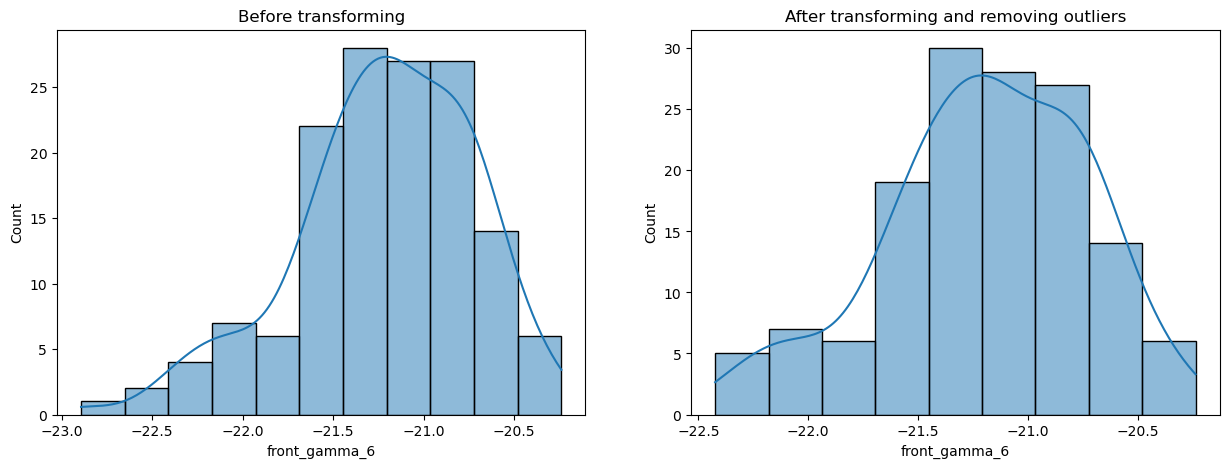

****Data still not normal****


In [94]:
# Handle outliers

frontal_power_6_sources=plot_and_remove_outliers(frontal_power_6_sources, "front_gamma_6", z_threshold=3, transform=False, connectivity=False, sources= True)

#### **Measure #2**: Gamma lateralization at 6 months

In [95]:
lat_df_gamma_6= lat_df_gamma.loc[lat_df_gamma.age == 6]
lat_df_gamma_6.rename(columns={"l_index":"gamma_lat_6"}, inplace=True)
lat_df_gamma_6=lat_df_gamma_6[["subject","gamma_lat_6"]]
lat_df_gamma_6

C:\Users\gabot\AppData\Local\Temp\ipykernel_18548\291140201.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  lat_df_gamma_6.rename(columns={"l_index":"gamma_lat_6"}, inplace=True)


,subject,gamma_lat_6
0,2,0.252155
3,3,0.040530
6,5,-0.016544
8,6,-0.164802
11,8,-0.108383
...,...,...
345,747,0.070970
347,748,-0.062543
351,915,0.042839
352,933,-0.097921


Shapiro normality test before:  ShapiroResult(statistic=0.9906175136566162, pvalue=0.45246610045433044)
Number of participants before: 144
Number of participants before: 139


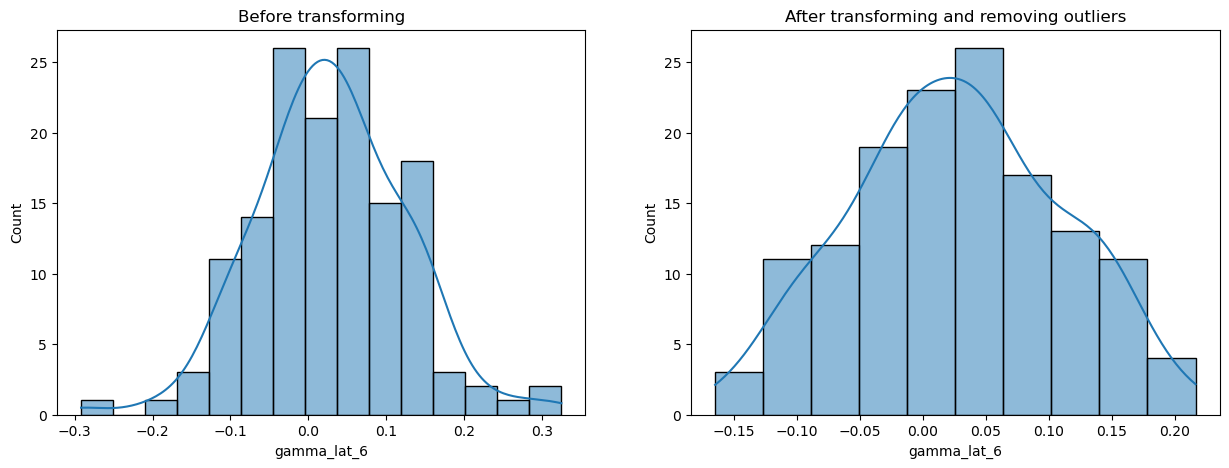

In [96]:
# handle outliers

lat_df_gamma_6=plot_and_remove_outliers(lat_df_gamma_6, "gamma_lat_6", z_threshold=3, transform=False)

### ***Measure #3-5** Connectivity for different regions

dmn ['caudalanteriorcingulate-rh', 'parahippocampal-rh', 'isthmuscingulate-rh', 'medialorbitofrontal-rh', 'posteriorcingulate-rh', 'precuneus-rh', 'rostralanteriorcingulate-rh', 'lateralorbitofrontal-rh', 'caudalanteriorcingulate-lh', 'parahippocampal-lh', 'isthmuscingulate-lh', 'medialorbitofrontal-lh', 'posteriorcingulate-lh']
attn ['inferiorparietal-rh', 'superiorparietal-rh', 'temporalpole-rh', 'rostralmiddlefrontal-rh', 'caudalmiddlefrontal-rh', 'supramarginal-rh', 'insula-rhinferiorparietal-lh', 'superiorparietal-lh', 'temporalpole-lh', 'rostralmiddlefrontal-lh', 'caudalmiddlefrontal-lh', 'supramarginal-lh', 'insula-lh']
visual ['cuneus-rh', 'fusiform-rh', 'lingual-rh', 'lateraloccipital-rhcuneus-lh', 'fusiform-lh', 'lingual-lh', 'lateraloccipital-lh']
auditory ['superiortemporal-rh', 'transversetemporal-rhsuperiortemporal-lh', 'transversetemporal-lh']
lang ['parsopercularis-lh', 'parsorbitalis-lh', 'parstriangularis-lh', 'middletemporal-lh', 'superiortemporal-lh', 'supramarginal

C:\Users\gabot\AppData\Local\Temp\ipykernel_18548\3471781112.py:78: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  con_df_age=con_df_age.groupby(["subject"]).mean().reset_index()


$Data is not normal$
Shapiro normality test before:  ShapiroResult(statistic=0.9368889927864075, pvalue=4.682915459852666e-06)
Number of participants before: 144
Number of participants before: 143


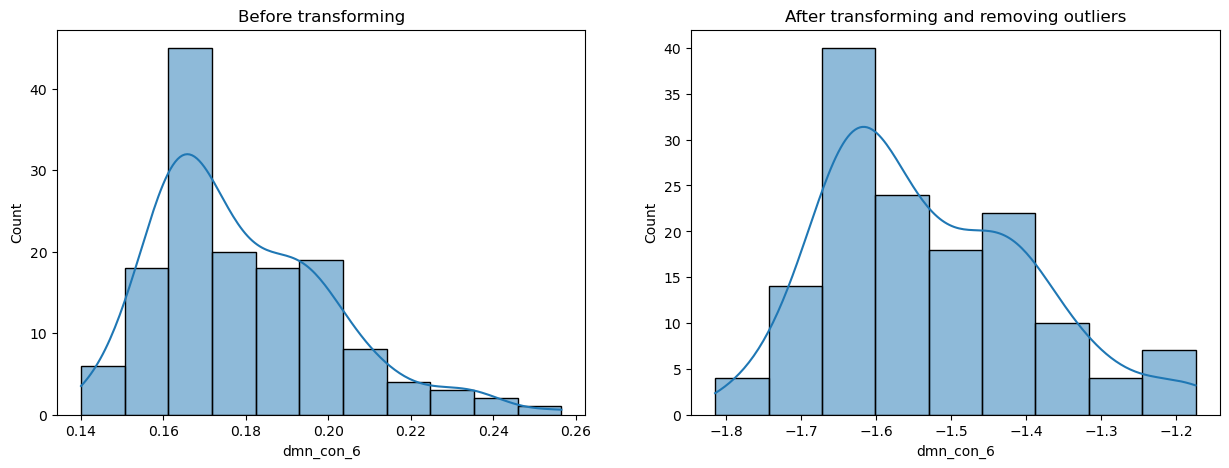

****Data still not normal****
$Data is not normal$
Shapiro normality test before:  ShapiroResult(statistic=0.9067894220352173, pvalue=5.3768893337746704e-08)
Number of participants before: 144
Number of participants before: 139


C:\Users\gabot\AppData\Local\Temp\ipykernel_18548\3471781112.py:93: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  con_df_age_left = con_df_age_left.groupby(["subject"]).mean().reset_index()


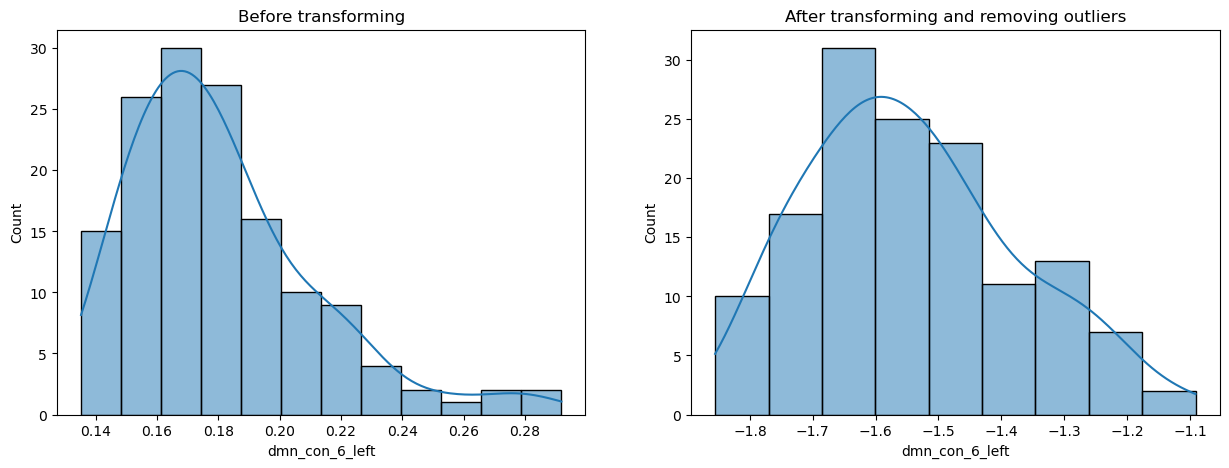

****Data still not normal****
$Data is not normal$
Shapiro normality test before:  ShapiroResult(statistic=0.9519873261451721, pvalue=6.871094228699803e-05)
Number of participants before: 144
Number of participants before: 144


C:\Users\gabot\AppData\Local\Temp\ipykernel_18548\3471781112.py:107: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  con_df_age_right = con_df_age_right.groupby(["subject"]).mean().reset_index()


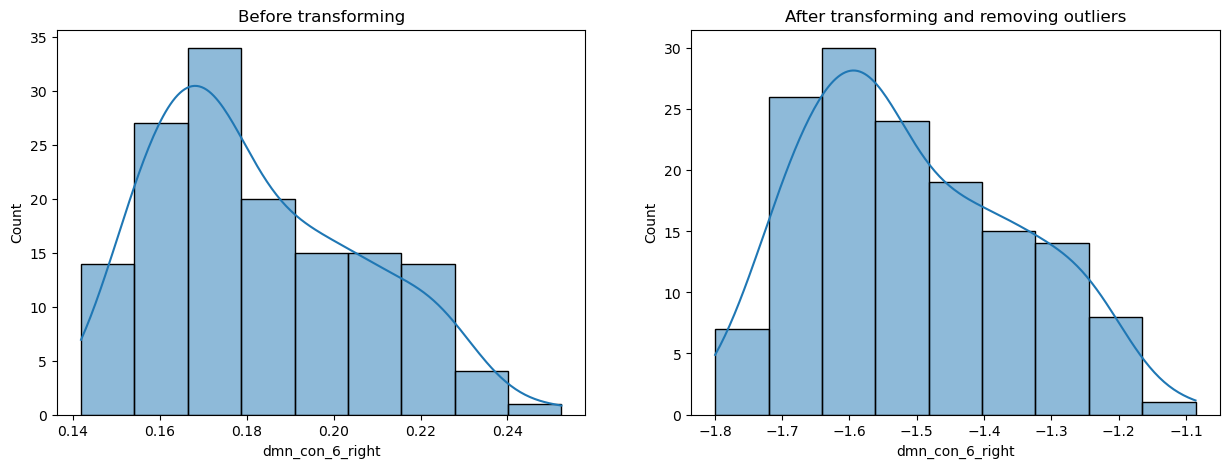

****Data still not normal****
$Data is not normal$
Shapiro normality test before:  ShapiroResult(statistic=0.6099642515182495, pvalue=1.4894745573173382e-18)
Number of participants before: 154
Number of participants before: 149


C:\Users\gabot\AppData\Local\Temp\ipykernel_18548\3471781112.py:78: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  con_df_age=con_df_age.groupby(["subject"]).mean().reset_index()


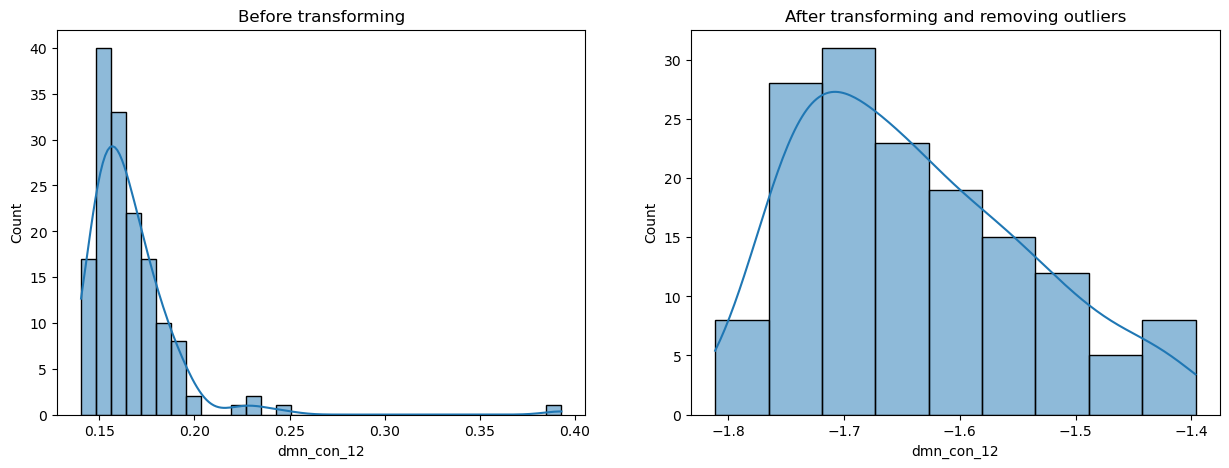

****Data still not normal****
$Data is not normal$
Shapiro normality test before:  ShapiroResult(statistic=0.6076791286468506, pvalue=1.324866752792628e-18)
Number of participants before: 154
Number of participants before: 147


C:\Users\gabot\AppData\Local\Temp\ipykernel_18548\3471781112.py:93: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  con_df_age_left = con_df_age_left.groupby(["subject"]).mean().reset_index()


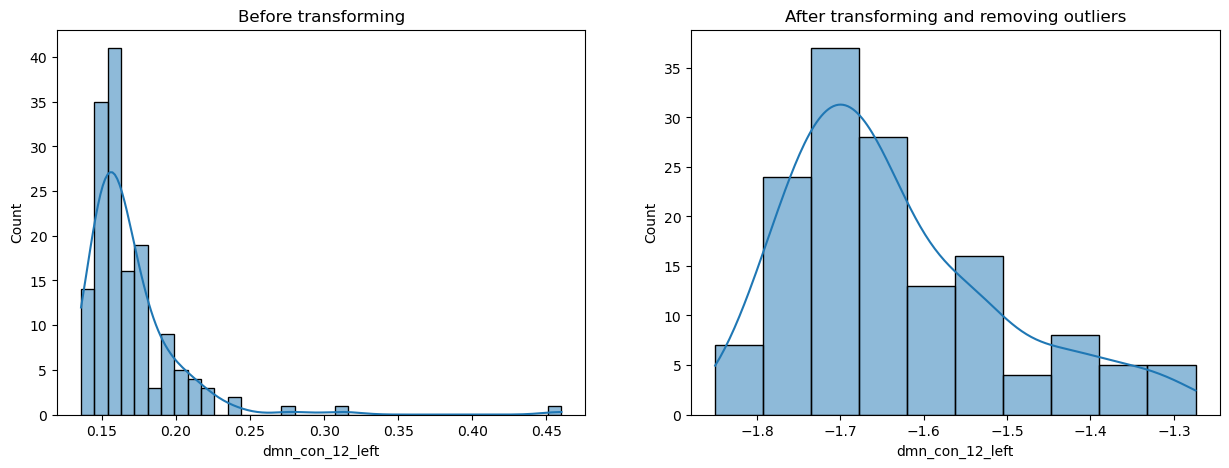

****Data still not normal****
$Data is not normal$
Shapiro normality test before:  ShapiroResult(statistic=0.7148928642272949, pvalue=6.178606659572425e-16)
Number of participants before: 154
Number of participants before: 147


C:\Users\gabot\AppData\Local\Temp\ipykernel_18548\3471781112.py:107: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  con_df_age_right = con_df_age_right.groupby(["subject"]).mean().reset_index()


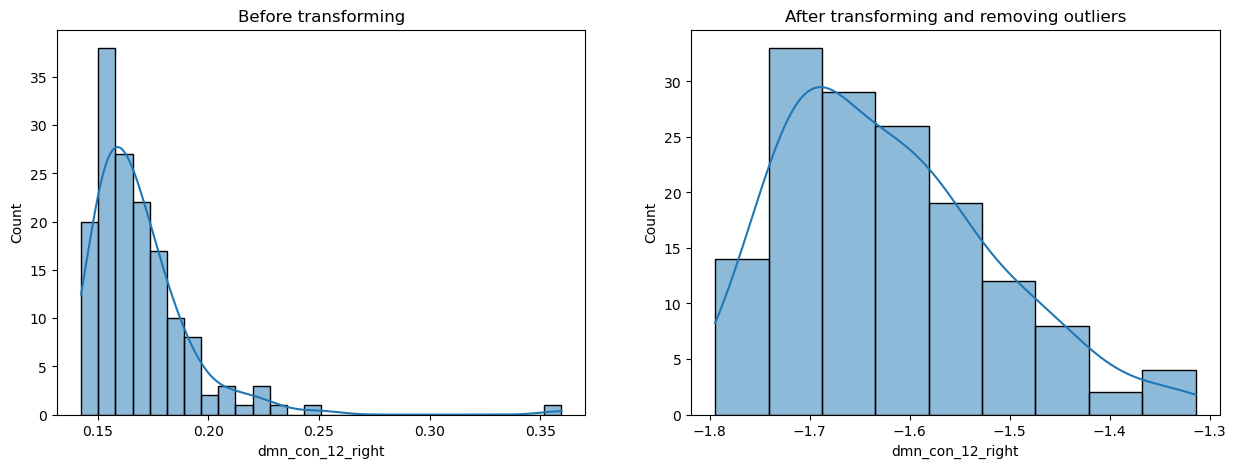

****Data still not normal****
$Data is not normal$
Shapiro normality test before:  ShapiroResult(statistic=0.9588131308555603, pvalue=0.0002642648760229349)
Number of participants before: 144
Number of participants before: 144


C:\Users\gabot\AppData\Local\Temp\ipykernel_18548\3471781112.py:78: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  con_df_age=con_df_age.groupby(["subject"]).mean().reset_index()


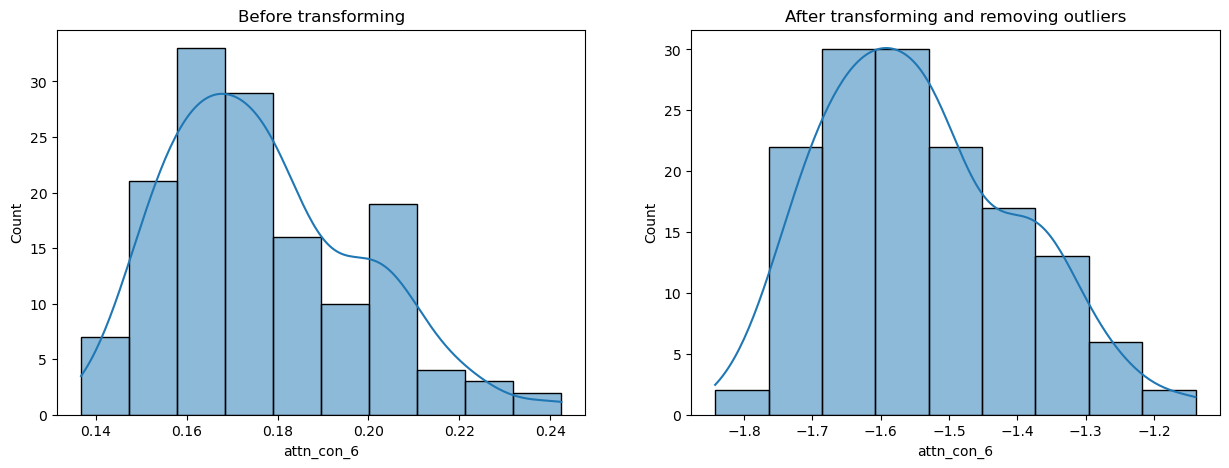

****Data still not normal****
$Data is not normal$
Shapiro normality test before:  ShapiroResult(statistic=0.9258542656898499, pvalue=8.099504498204624e-07)
Number of participants before: 144
Number of participants before: 141


C:\Users\gabot\AppData\Local\Temp\ipykernel_18548\3471781112.py:93: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  con_df_age_left = con_df_age_left.groupby(["subject"]).mean().reset_index()


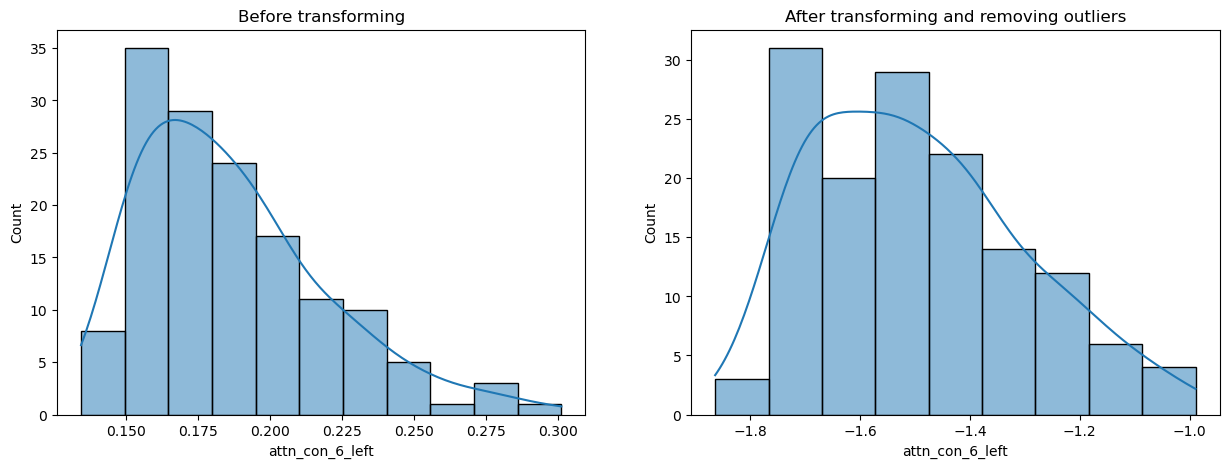

****Data still not normal****
$Data is not normal$
Shapiro normality test before:  ShapiroResult(statistic=0.921963095664978, pvalue=4.517839897744125e-07)
Number of participants before: 144


C:\Users\gabot\AppData\Local\Temp\ipykernel_18548\3471781112.py:107: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  con_df_age_right = con_df_age_right.groupby(["subject"]).mean().reset_index()


Number of participants before: 142


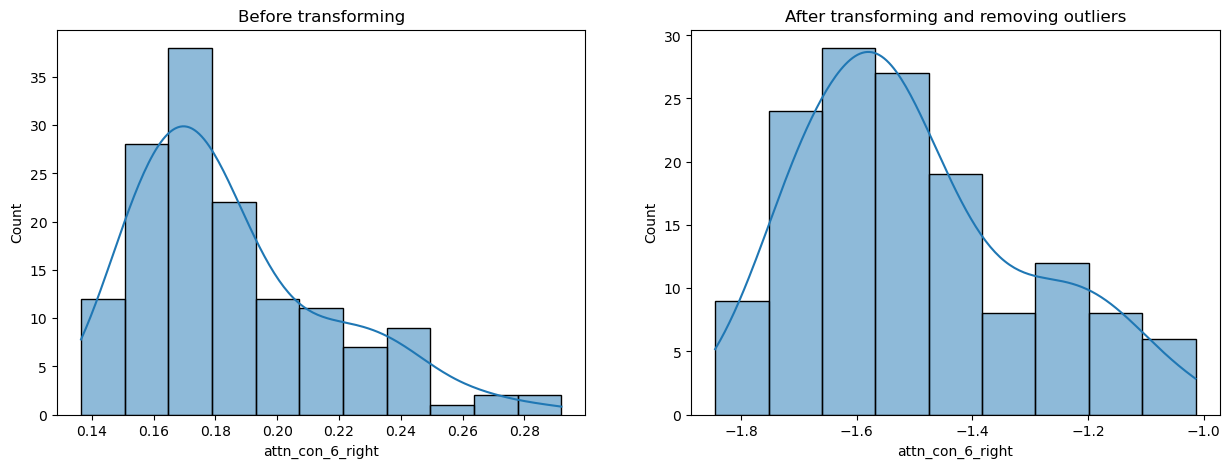

****Data still not normal****
$Data is not normal$
Shapiro normality test before:  ShapiroResult(statistic=0.7281094789505005, pvalue=1.4740220872841024e-15)
Number of participants before: 154
Number of participants before: 148


C:\Users\gabot\AppData\Local\Temp\ipykernel_18548\3471781112.py:78: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  con_df_age=con_df_age.groupby(["subject"]).mean().reset_index()


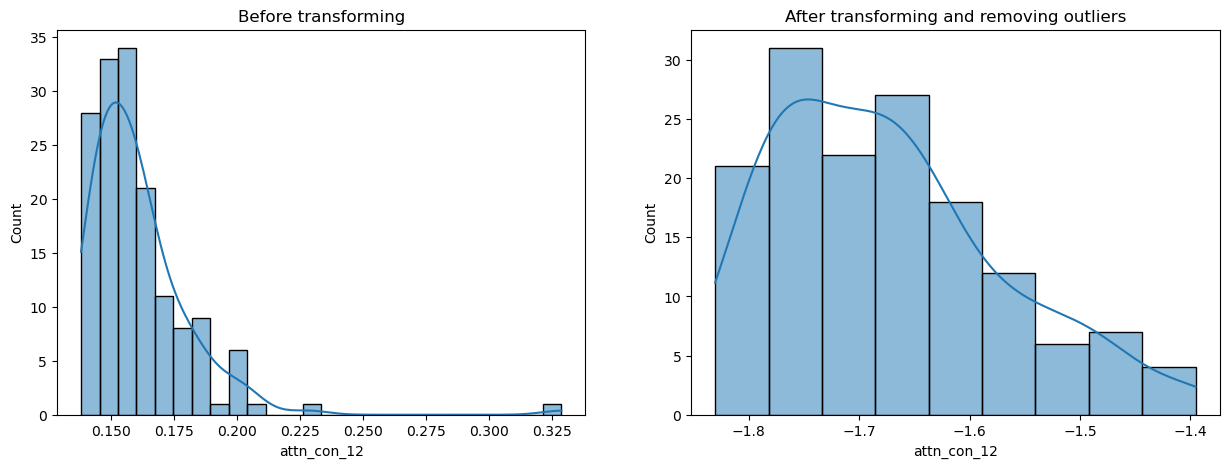

****Data still not normal****
$Data is not normal$
Shapiro normality test before:  ShapiroResult(statistic=0.7021809816360474, pvalue=2.7509467545826216e-16)
Number of participants before: 154
Number of participants before: 149


C:\Users\gabot\AppData\Local\Temp\ipykernel_18548\3471781112.py:93: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  con_df_age_left = con_df_age_left.groupby(["subject"]).mean().reset_index()


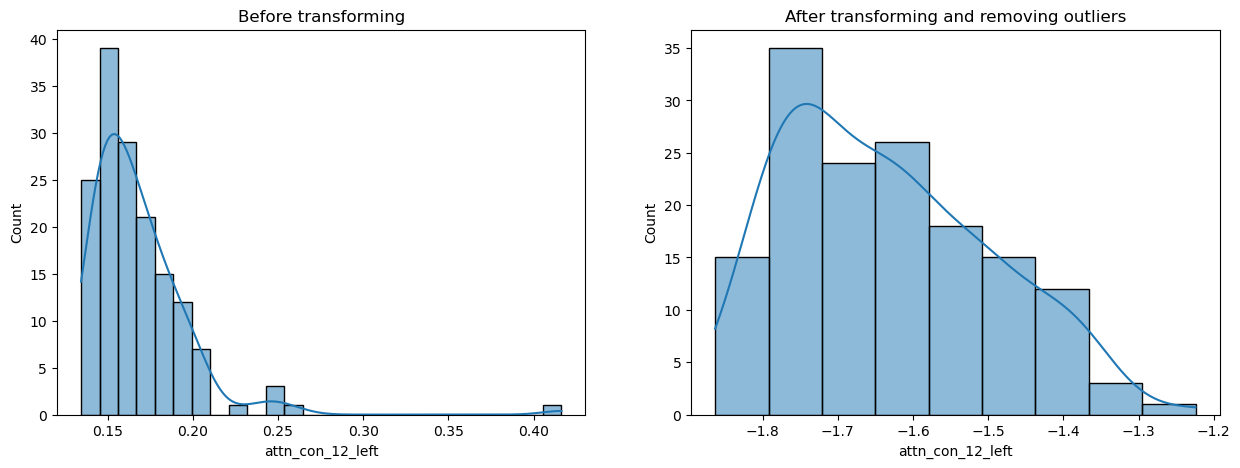

****Data still not normal****
$Data is not normal$
Shapiro normality test before:  ShapiroResult(statistic=0.8116327524185181, pvalue=8.330020158896223e-13)
Number of participants before: 154
Number of participants before: 146


C:\Users\gabot\AppData\Local\Temp\ipykernel_18548\3471781112.py:107: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  con_df_age_right = con_df_age_right.groupby(["subject"]).mean().reset_index()


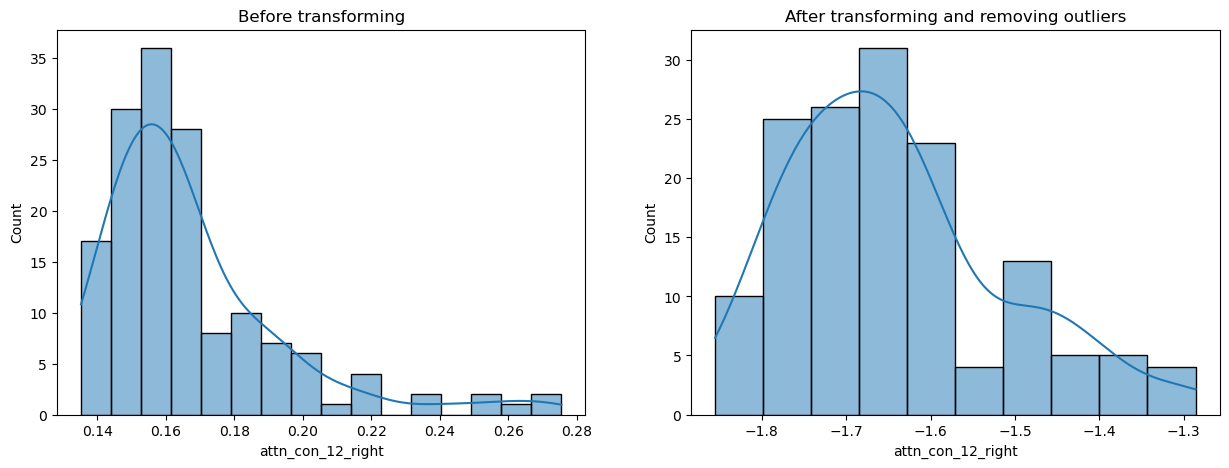

****Data still not normal****
$Data is not normal$
Shapiro normality test before:  ShapiroResult(statistic=0.8459007740020752, pvalue=5.56320475797456e-11)
Number of participants before: 144
Number of participants before: 141


C:\Users\gabot\AppData\Local\Temp\ipykernel_18548\3471781112.py:78: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  con_df_age=con_df_age.groupby(["subject"]).mean().reset_index()


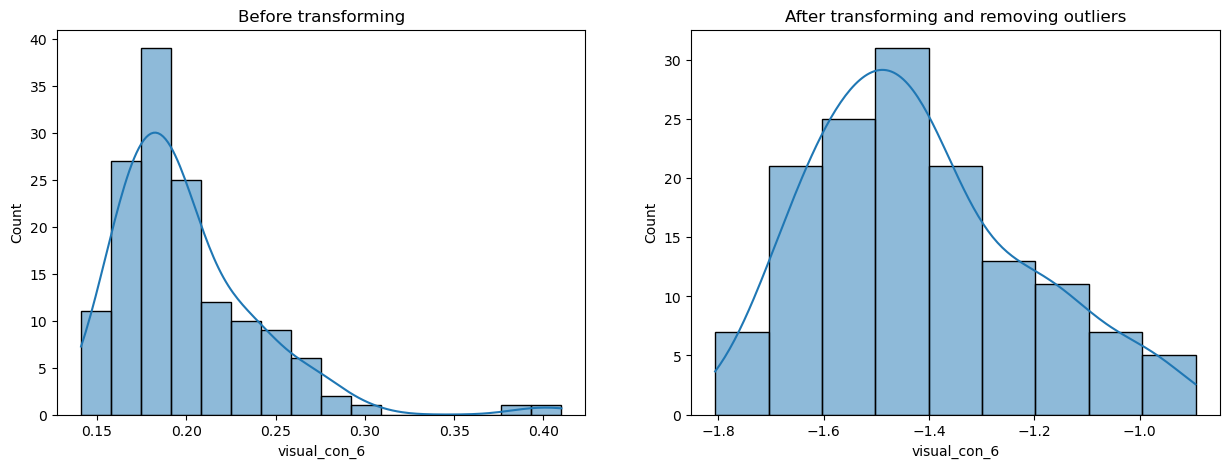

****Data still not normal****
$Data is not normal$
Shapiro normality test before:  ShapiroResult(statistic=0.822981595993042, pvalue=6.690075576853971e-12)
Number of participants before: 144
Number of participants before: 139


C:\Users\gabot\AppData\Local\Temp\ipykernel_18548\3471781112.py:93: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  con_df_age_left = con_df_age_left.groupby(["subject"]).mean().reset_index()


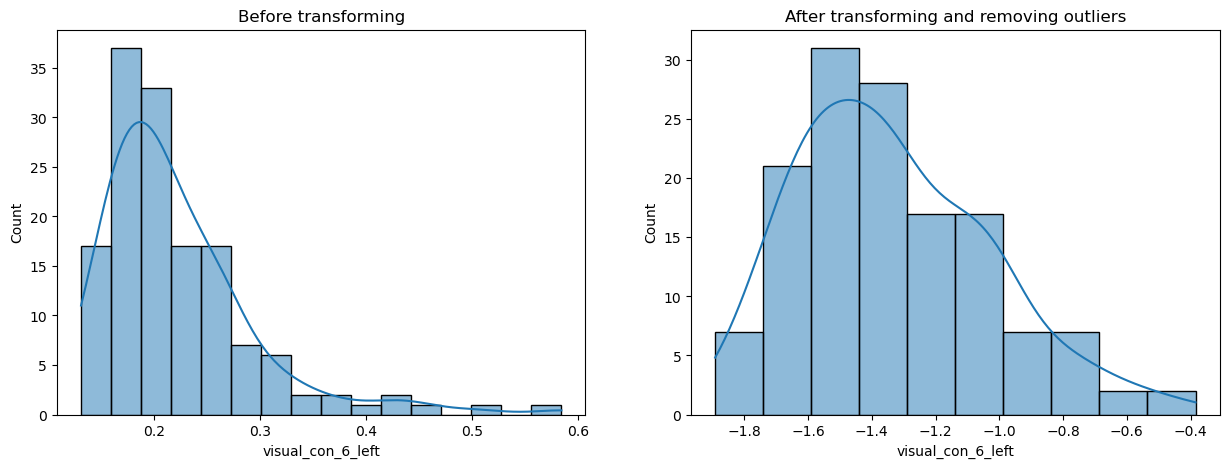

****Data still not normal****
$Data is not normal$
Shapiro normality test before:  ShapiroResult(statistic=0.8129040598869324, pvalue=2.795116135073661e-12)
Number of participants before: 144
Number of participants before: 139


C:\Users\gabot\AppData\Local\Temp\ipykernel_18548\3471781112.py:107: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  con_df_age_right = con_df_age_right.groupby(["subject"]).mean().reset_index()


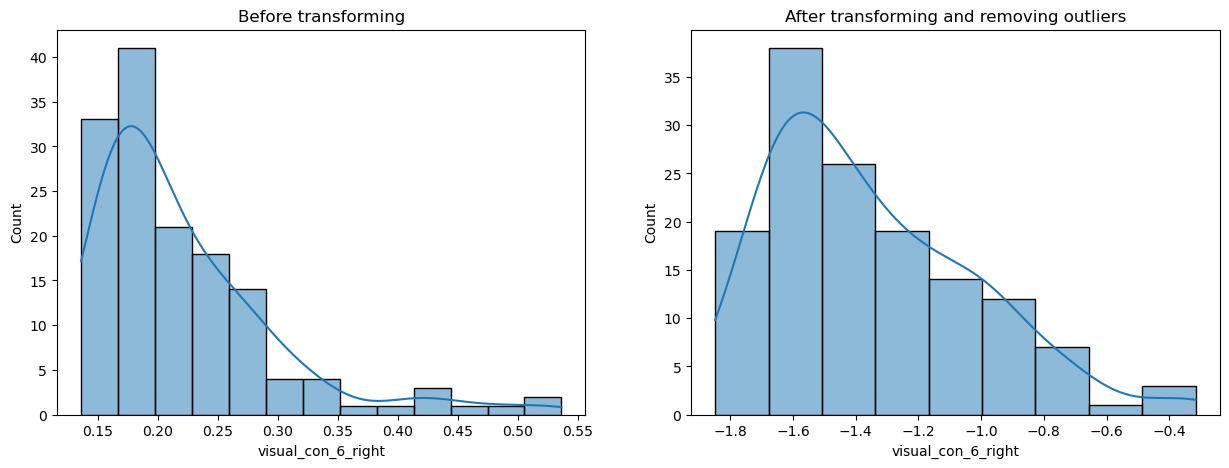

****Data still not normal****
$Data is not normal$
Shapiro normality test before:  ShapiroResult(statistic=0.8819538354873657, pvalue=9.925210653349836e-10)
Number of participants before: 154
Number of participants before: 149


C:\Users\gabot\AppData\Local\Temp\ipykernel_18548\3471781112.py:78: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  con_df_age=con_df_age.groupby(["subject"]).mean().reset_index()


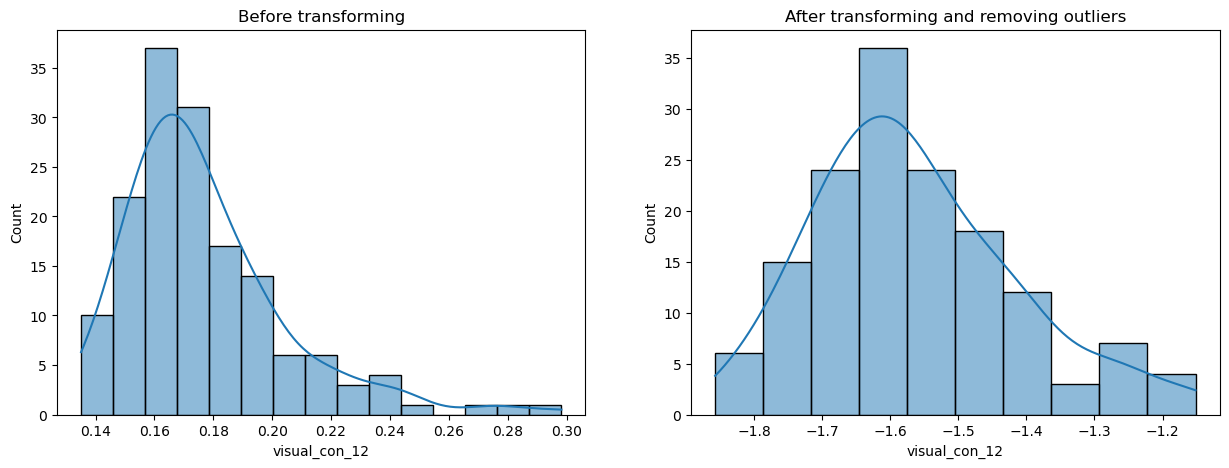

****Data still not normal****
$Data is not normal$
Shapiro normality test before:  ShapiroResult(statistic=0.6936805248260498, pvalue=1.6238180111214533e-16)
Number of participants before: 154
Number of participants before: 148


C:\Users\gabot\AppData\Local\Temp\ipykernel_18548\3471781112.py:93: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  con_df_age_left = con_df_age_left.groupby(["subject"]).mean().reset_index()


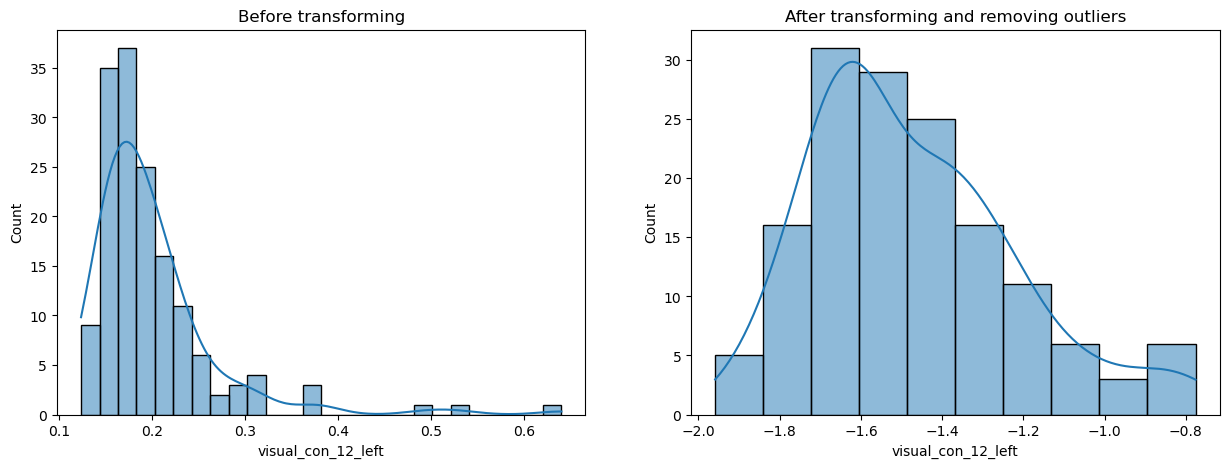

****Data still not normal****
$Data is not normal$
Shapiro normality test before:  ShapiroResult(statistic=0.8358101844787598, pvalue=7.491541241522182e-12)
Number of participants before: 154
Number of participants before: 144


C:\Users\gabot\AppData\Local\Temp\ipykernel_18548\3471781112.py:107: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  con_df_age_right = con_df_age_right.groupby(["subject"]).mean().reset_index()


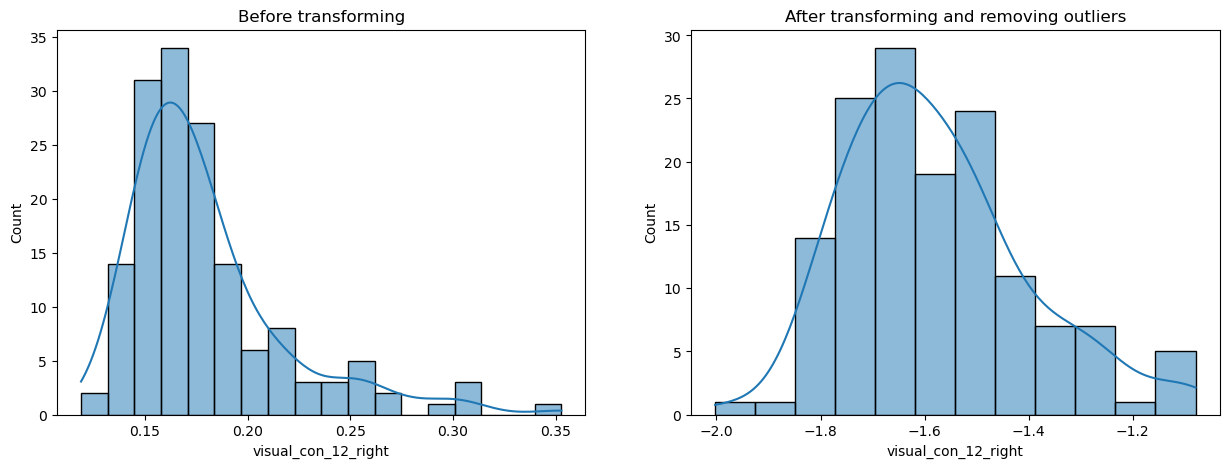

****Data still not normal****
$Data is not normal$
Shapiro normality test before:  ShapiroResult(statistic=0.8425540328025818, pvalue=4.0320455307885084e-11)
Number of participants before: 144
Number of participants before: 140


C:\Users\gabot\AppData\Local\Temp\ipykernel_18548\3471781112.py:78: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  con_df_age=con_df_age.groupby(["subject"]).mean().reset_index()


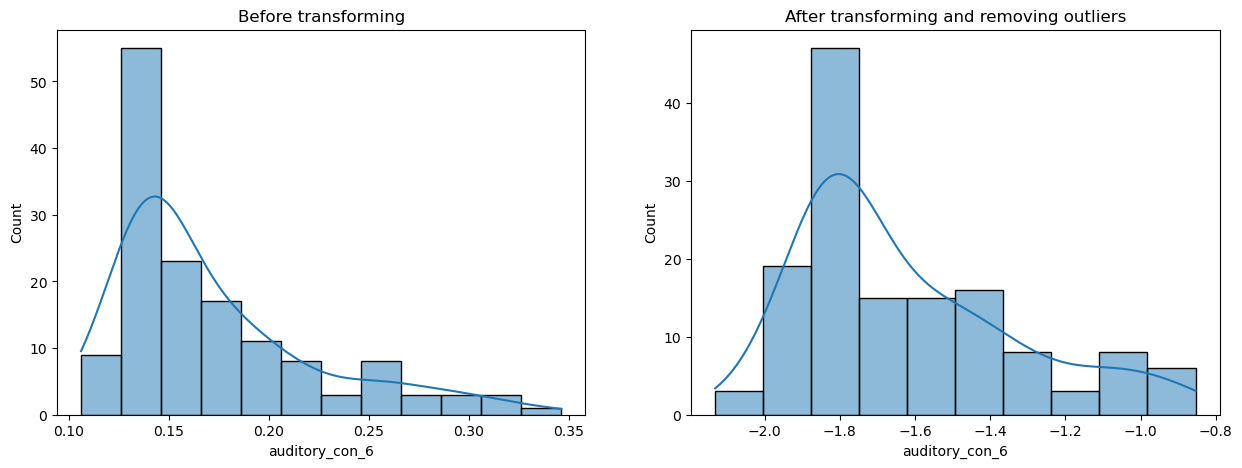

****Data still not normal****
$Data is not normal$
Shapiro normality test before:  ShapiroResult(statistic=0.6273844242095947, pvalue=3.7002911406309316e-18)
Number of participants before: 154
Number of participants before: 143


C:\Users\gabot\AppData\Local\Temp\ipykernel_18548\3471781112.py:78: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  con_df_age=con_df_age.groupby(["subject"]).mean().reset_index()


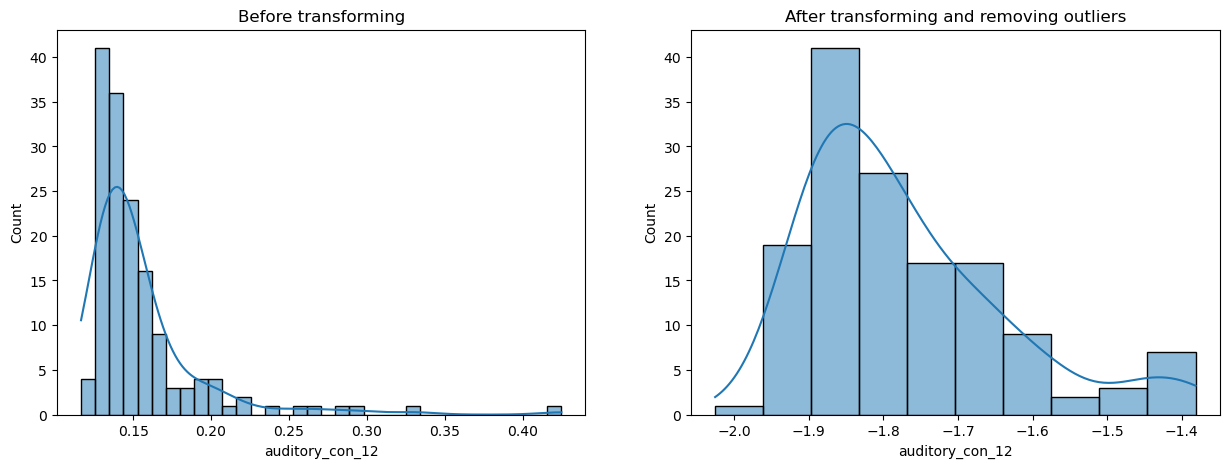

****Data still not normal****
$Data is not normal$
Shapiro normality test before:  ShapiroResult(statistic=0.9422944784164429, pvalue=1.1749329132726416e-05)
Number of participants before: 144
Number of participants before: 144


C:\Users\gabot\AppData\Local\Temp\ipykernel_18548\3471781112.py:78: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  con_df_age=con_df_age.groupby(["subject"]).mean().reset_index()


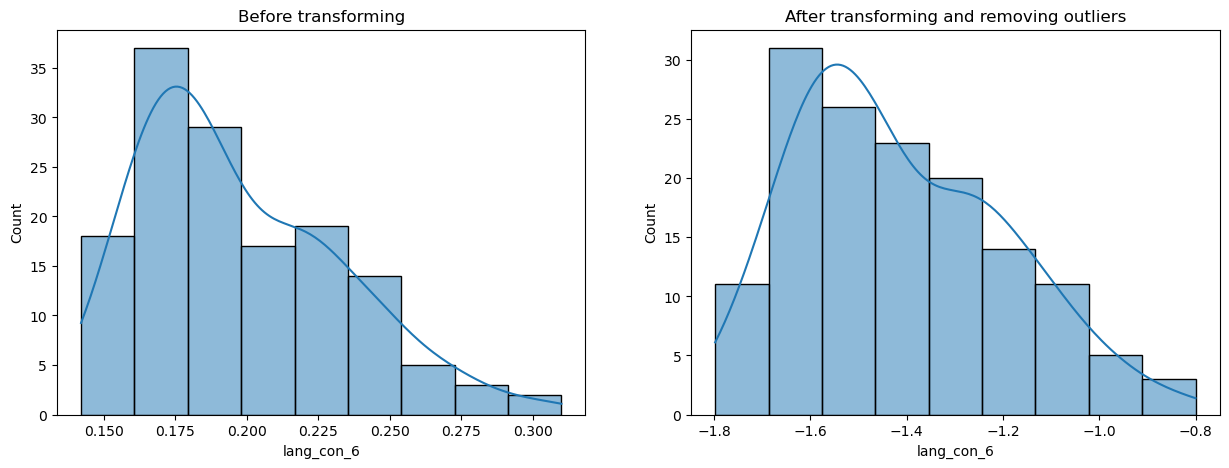

****Data still not normal****
$Data is not normal$
Shapiro normality test before:  ShapiroResult(statistic=0.9422944784164429, pvalue=1.1749329132726416e-05)
Number of participants before: 144
Number of participants before: 144


C:\Users\gabot\AppData\Local\Temp\ipykernel_18548\3471781112.py:93: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  con_df_age_left = con_df_age_left.groupby(["subject"]).mean().reset_index()


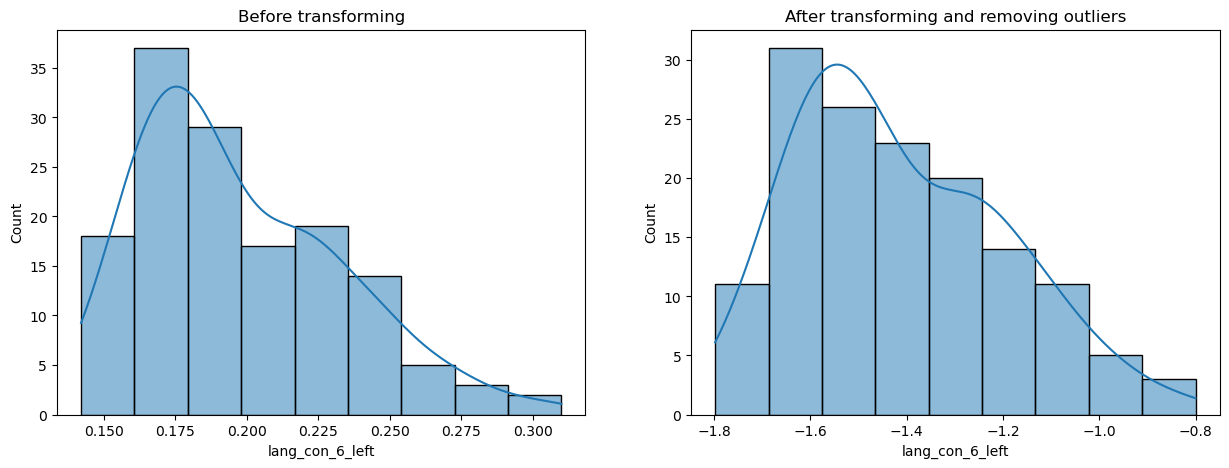

****Data still not normal****
$Data is not normal$
Shapiro normality test before:  ShapiroResult(statistic=0.7530204057693481, pvalue=8.27504433248763e-15)
Number of participants before: 154


C:\Users\gabot\AppData\Local\Temp\ipykernel_18548\3471781112.py:107: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  con_df_age_right = con_df_age_right.groupby(["subject"]).mean().reset_index()
C:\Users\gabot\AppData\Local\Temp\ipykernel_18548\3471781112.py:78: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  con_df_age=con_df_age.groupby(["subject"]).mean().reset_index()


Number of participants before: 145


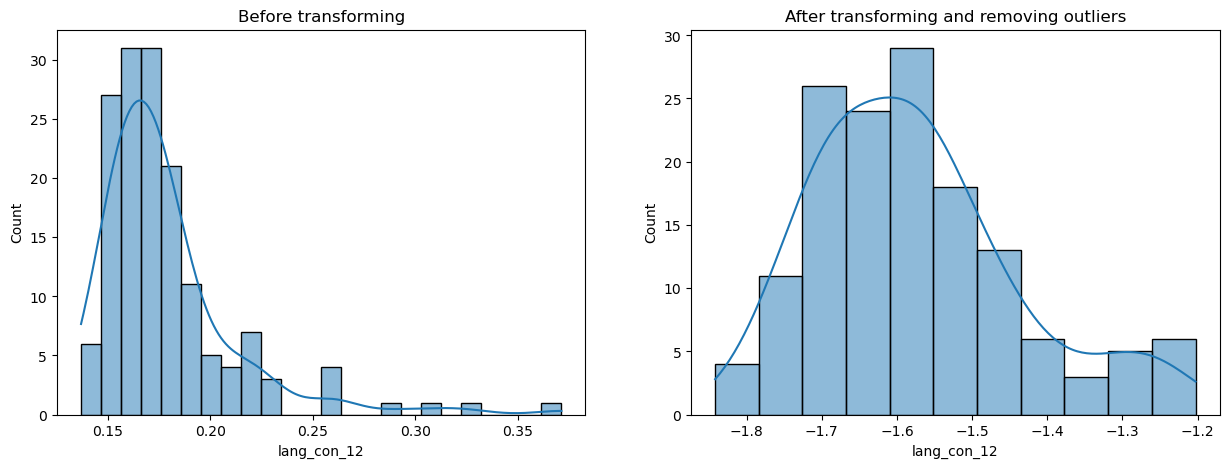

****Data still not normal****
$Data is not normal$
Shapiro normality test before:  ShapiroResult(statistic=0.7530204057693481, pvalue=8.27504433248763e-15)
Number of participants before: 154
Number of participants before: 145


C:\Users\gabot\AppData\Local\Temp\ipykernel_18548\3471781112.py:93: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  con_df_age_left = con_df_age_left.groupby(["subject"]).mean().reset_index()


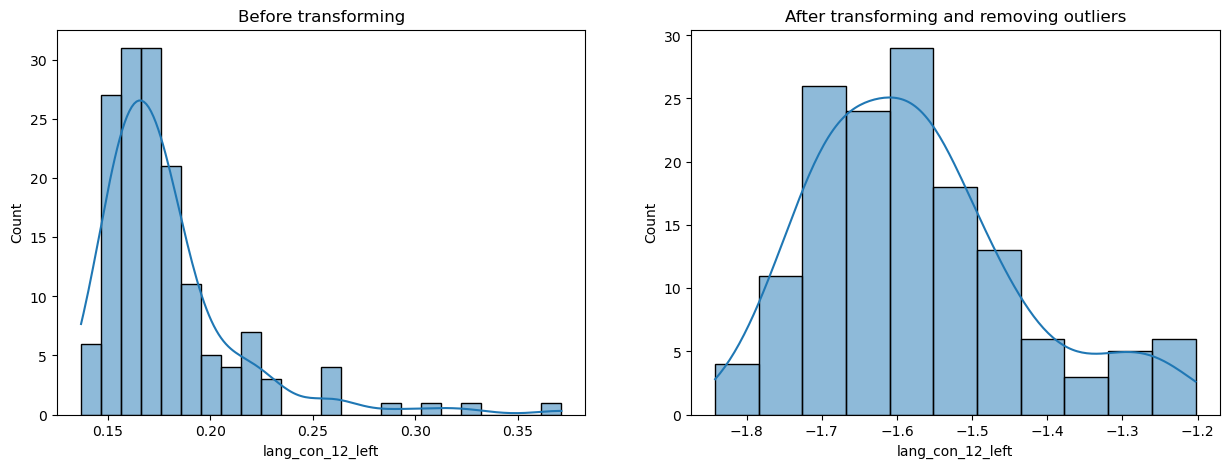

****Data still not normal****
$Data is not normal$
Shapiro normality test before:  ShapiroResult(statistic=0.9432570338249207, pvalue=1.3904579645895865e-05)
Number of participants before: 144
Number of participants before: 142


C:\Users\gabot\AppData\Local\Temp\ipykernel_18548\3471781112.py:107: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  con_df_age_right = con_df_age_right.groupby(["subject"]).mean().reset_index()
C:\Users\gabot\AppData\Local\Temp\ipykernel_18548\3471781112.py:78: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  con_df_age=con_df_age.groupby(["subject"]).mean().reset_index()


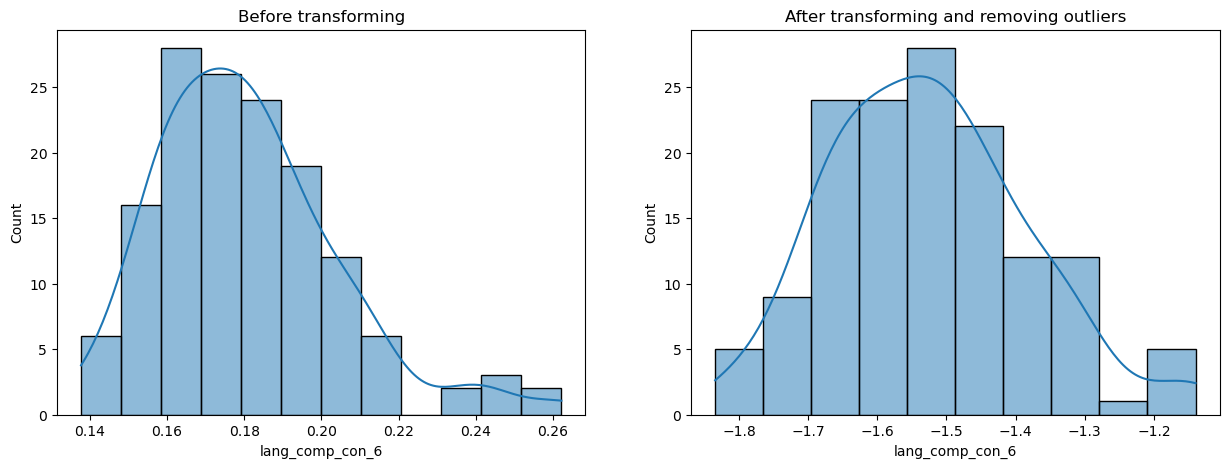

C:\Users\gabot\AppData\Local\Temp\ipykernel_18548\3471781112.py:93: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  con_df_age_left = con_df_age_left.groupby(["subject"]).mean().reset_index()


$Data is not normal$
Shapiro normality test before:  ShapiroResult(statistic=0.936998188495636, pvalue=4.768775397678837e-06)
Number of participants before: 144
Number of participants before: 144


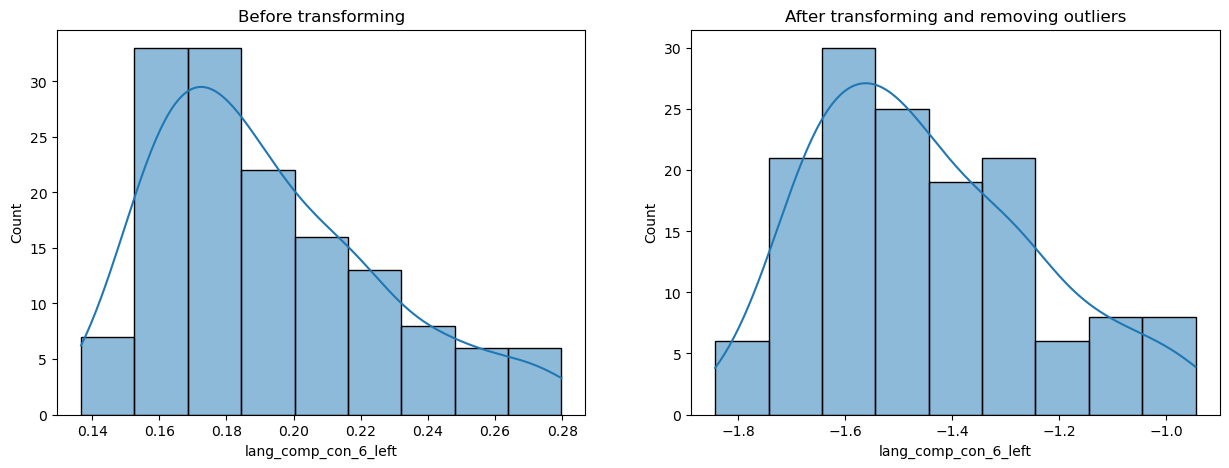

****Data still not normal****
$Data is not normal$
Shapiro normality test before:  ShapiroResult(statistic=0.812685489654541, pvalue=2.7436919923518044e-12)
Number of participants before: 144
Number of participants before: 141


C:\Users\gabot\AppData\Local\Temp\ipykernel_18548\3471781112.py:107: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  con_df_age_right = con_df_age_right.groupby(["subject"]).mean().reset_index()


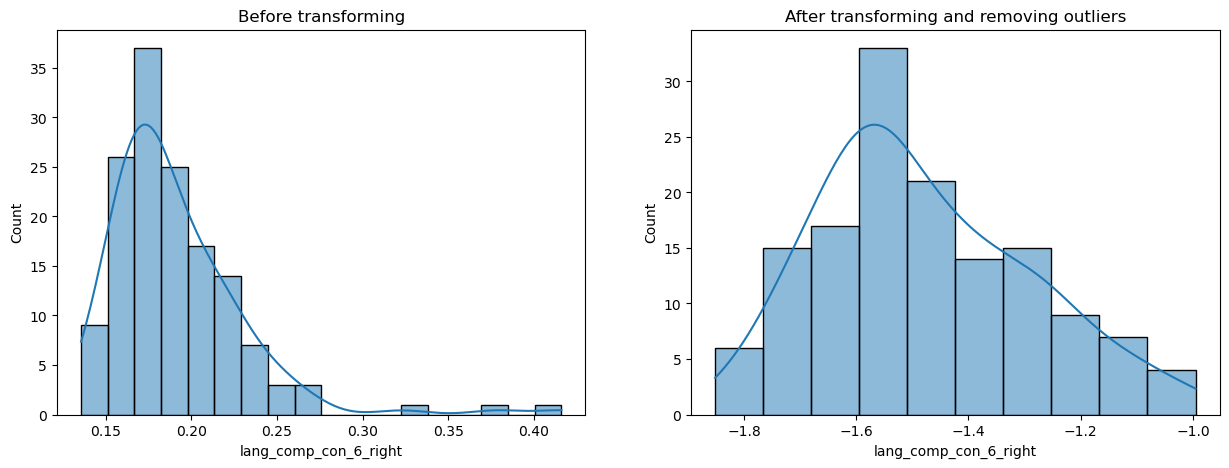

****Data still not normal****
$Data is not normal$
Shapiro normality test before:  ShapiroResult(statistic=0.7146226167678833, pvalue=6.071607340092894e-16)
Number of participants before: 154


C:\Users\gabot\AppData\Local\Temp\ipykernel_18548\3471781112.py:78: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  con_df_age=con_df_age.groupby(["subject"]).mean().reset_index()


Number of participants before: 147


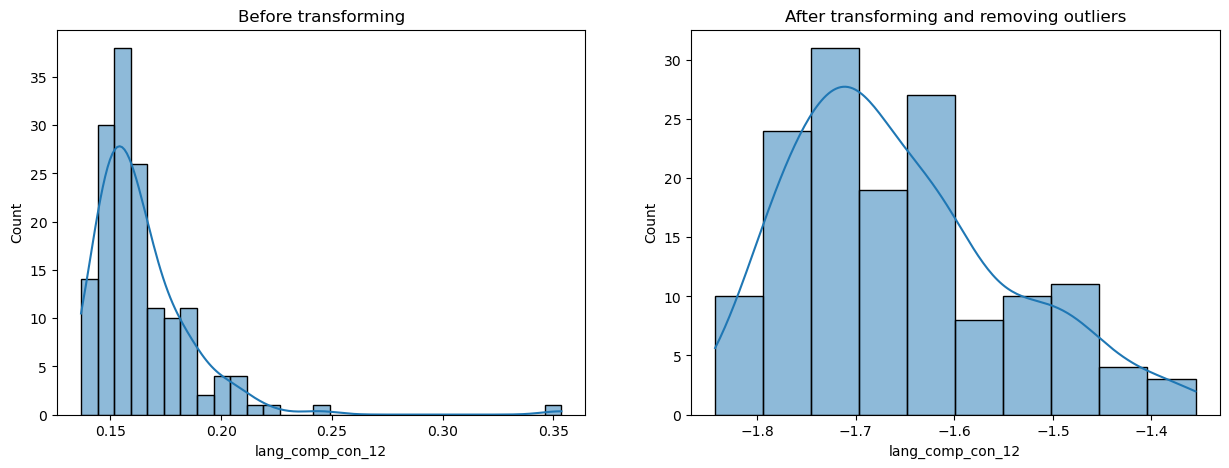

****Data still not normal****
$Data is not normal$
Shapiro normality test before:  ShapiroResult(statistic=0.7351620197296143, pvalue=2.3738246577567537e-15)
Number of participants before: 154
Number of participants before: 144


C:\Users\gabot\AppData\Local\Temp\ipykernel_18548\3471781112.py:93: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  con_df_age_left = con_df_age_left.groupby(["subject"]).mean().reset_index()


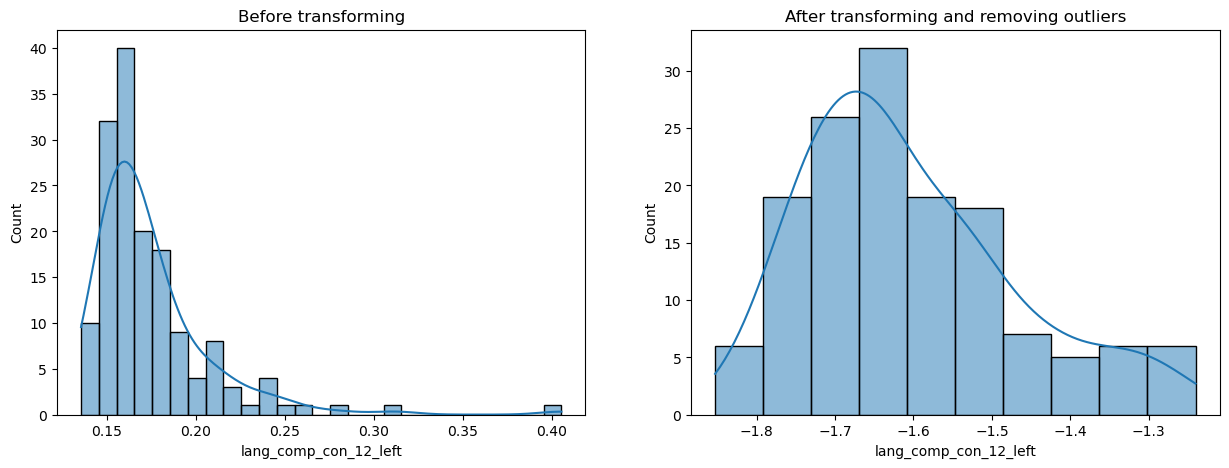

****Data still not normal****
$Data is not normal$
Shapiro normality test before:  ShapiroResult(statistic=0.8191606998443604, pvalue=1.6150567211728473e-12)
Number of participants before: 154
Number of participants before: 145


C:\Users\gabot\AppData\Local\Temp\ipykernel_18548\3471781112.py:107: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  con_df_age_right = con_df_age_right.groupby(["subject"]).mean().reset_index()


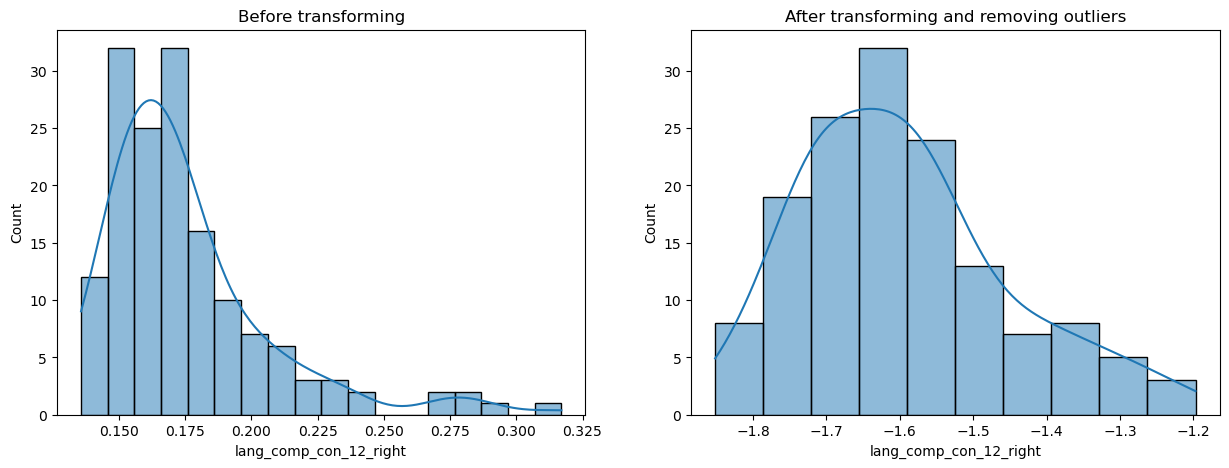

****Data still not normal****
$Data is not normal$
Shapiro normality test before:  ShapiroResult(statistic=0.8906826972961426, pvalue=6.97164725949051e-09)
Number of participants before: 144
Number of participants before: 140


C:\Users\gabot\AppData\Local\Temp\ipykernel_18548\3471781112.py:78: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  con_df_age=con_df_age.groupby(["subject"]).mean().reset_index()


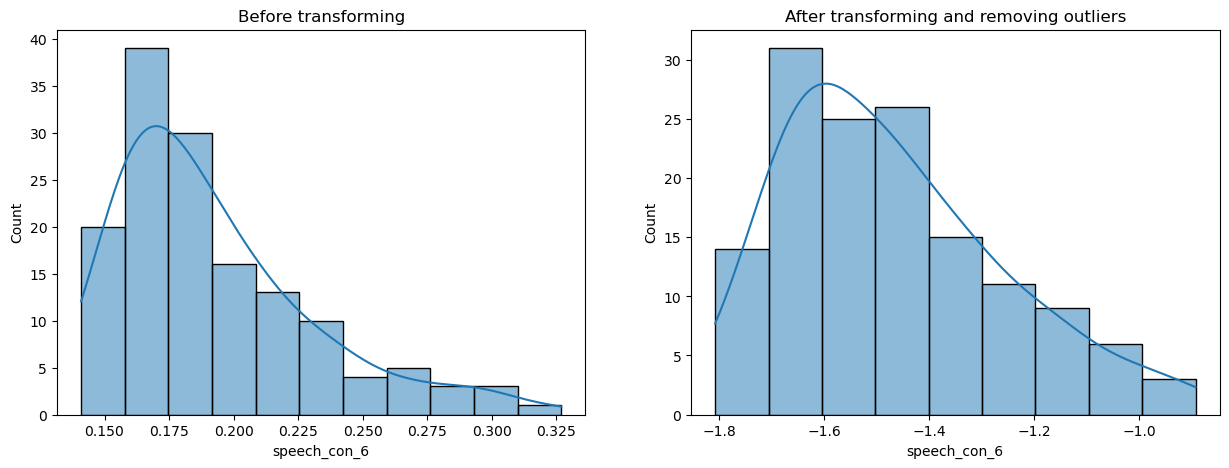

****Data still not normal****
$Data is not normal$
Shapiro normality test before:  ShapiroResult(statistic=0.8906826972961426, pvalue=6.97164725949051e-09)
Number of participants before: 144
Number of participants before: 140


C:\Users\gabot\AppData\Local\Temp\ipykernel_18548\3471781112.py:93: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  con_df_age_left = con_df_age_left.groupby(["subject"]).mean().reset_index()


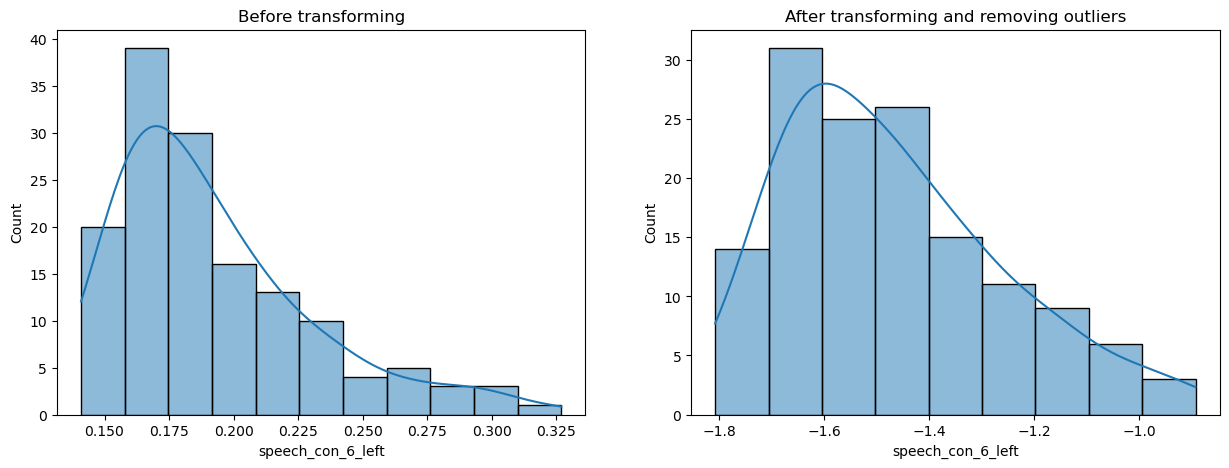

****Data still not normal****
$Data is not normal$
Shapiro normality test before:  ShapiroResult(statistic=0.7254936695098877, pvalue=1.2380297084539898e-15)
Number of participants before: 154


C:\Users\gabot\AppData\Local\Temp\ipykernel_18548\3471781112.py:107: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  con_df_age_right = con_df_age_right.groupby(["subject"]).mean().reset_index()
C:\Users\gabot\AppData\Local\Temp\ipykernel_18548\3471781112.py:78: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  con_df_age=con_df_age.groupby(["subject"]).mean().reset_index()


Number of participants before: 142


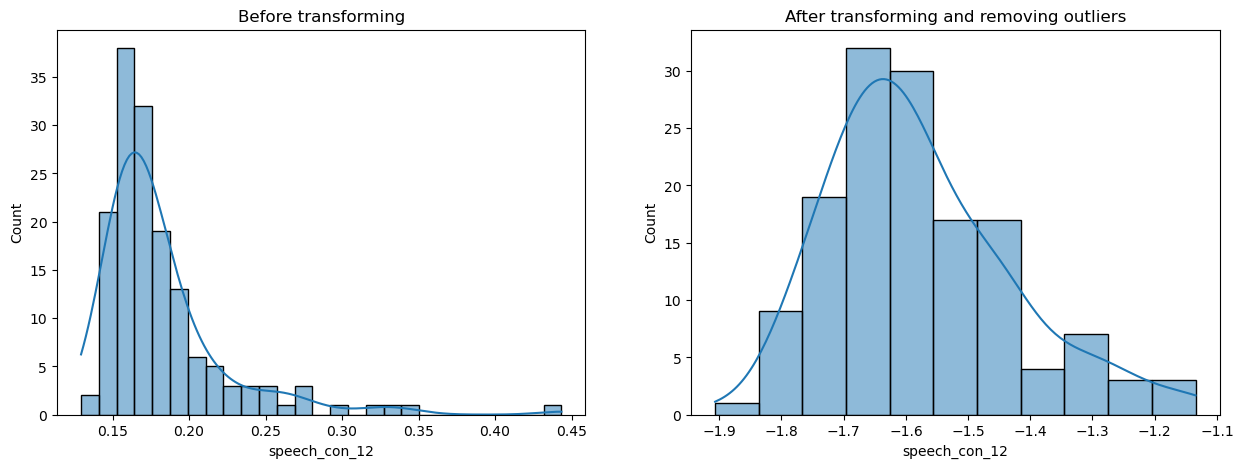

****Data still not normal****
$Data is not normal$
Shapiro normality test before:  ShapiroResult(statistic=0.7254936695098877, pvalue=1.2380297084539898e-15)
Number of participants before: 154
Number of participants before: 142


C:\Users\gabot\AppData\Local\Temp\ipykernel_18548\3471781112.py:93: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  con_df_age_left = con_df_age_left.groupby(["subject"]).mean().reset_index()


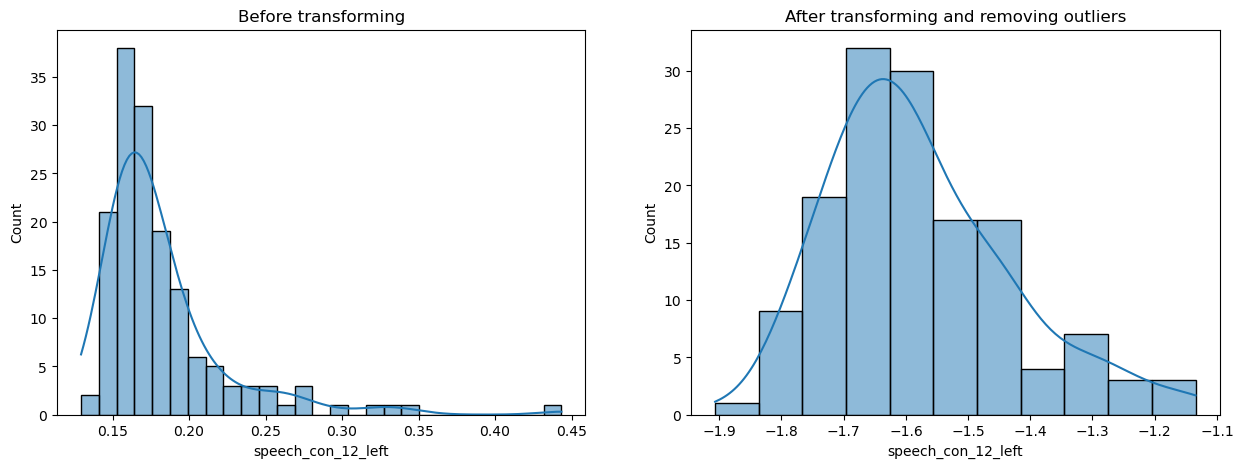

****Data still not normal****


C:\Users\gabot\AppData\Local\Temp\ipykernel_18548\3471781112.py:107: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  con_df_age_right = con_df_age_right.groupby(["subject"]).mean().reset_index()


In [ ]:
lat_rois= {   
"dmn":[ # right hemisphere
     "caudalanteriorcingulate-rh",    'parahippocampal-rh','isthmuscingulate-rh',
            'medialorbitofrontal-rh','posteriorcingulate-rh',
       'precuneus-rh', 'rostralanteriorcingulate-rh', 'lateralorbitofrontal-rh', 
       # left hemisphere
         "caudalanteriorcingulate-lh",    'parahippocampal-lh','isthmuscingulate-lh',
                'medialorbitofrontal-lh','posteriorcingulate-lh' 
       ],
"attn":[ # right hemisphere
     'inferiorparietal-rh'   , 'superiorparietal-rh', 'temporalpole-rh' ,
             'rostralmiddlefrontal-rh','caudalmiddlefrontal-rh','supramarginal-rh','insula-rh'
             
         # left hemisphere
        'inferiorparietal-lh'   , 'superiorparietal-lh', 'temporalpole-lh' ,
                'rostralmiddlefrontal-lh','caudalmiddlefrontal-lh','supramarginal-lh','insula-lh'
             ],
"visual": [ # right hemisphere
    
    'cuneus-rh','fusiform-rh','lingual-rh','lateraloccipital-rh'
     # left hemisphere
        'cuneus-lh','fusiform-lh','lingual-lh','lateraloccipital-lh'
    ] ,

"auditory": ["superiortemporal-rh",  "transversetemporal-rh"
                "superiortemporal-lh", "transversetemporal-lh"
             ],
 
 # Source: Yuan, Binke, et al. "The domain-separation language network dynamics in resting state support its flexible functional
 #  segregation and integration during language and speech processing." NeuroImage 274 (2023): 120132.
"lang": [ 
          # left hemisphere
        'parsopercularis-lh', 'parsorbitalis-lh', 'parstriangularis-lh', # IFG
                    "middletemporal-lh", "superiortemporal-lh", # Temporal
            "supramarginal-lh", "inferiorparietal-lh" # Parietal
        ],
"lang_comp": [# Bilateral MTG
        'middletemporal-lh', 'middletemporal-rh',

        # Bilateral IPL
        'inferiorparietal-lh', 'inferiorparietal-rh',

        # Bilateral Supramarginal
        'supramarginal-lh', 'supramarginal-rh',

        # Bilateral IFG
        'parsopercularis-lh', 'parsopercularis-rh',
        'parstriangularis-lh', 'parstriangularis-rh',
        'parsorbitalis-lh', 'parsorbitalis-rh'], 

"speech": [
    # Left IFG
        'parsopercularis-lh',  
        'parstriangularis-lh', 
        'parsorbitalis-lh',  

        # Left Precentral 
        'precentral-lh',  

        # Left STG     
          'superiortemporal-lh'
        ]}
for network, region in lat_rois.items():
    condition = con_df_region_gamma['source'].isin(region) & con_df_region_gamma['target'].isin(region)
    con_df_region_gamma[network] = condition
    print(network, region)  

# Initialize an empty list to collect dataframes for merging later
all_dfs = []

# Loop over each network in lat_rois
for network in lat_rois.keys():
    # For both age groups (6 and 12 months)
    for age in [6, 12]:
        # Create a new column for the total connectivity (both left and right)
        con_df_age = con_df_region_gamma.loc[con_df_region_gamma.age == age]
        con_df_age = con_df_age[con_df_age[network]]  # Filter by network connectivity
        con_df_age=con_df_age.groupby(["subject"]).mean().reset_index()
        con_df_age.rename(columns={"connectivity": f"{network}_con_{age}"}, inplace=True)
        con_df_age = con_df_age[["subject", f"{network}_con_{age}"]]

        # handle outliers
        con_df_age=plot_and_remove_outliers(con_df_age, f"{network}_con_{age}", z_threshold=3, 
                                            transform=False, connectivity = True)
        all_dfs.append(con_df_age)
        
        if network=="auditory":
            continue
        # Left hemisphere connectivity for the current age group
        con_df_age_left = con_df_region_gamma.loc[con_df_region_gamma.age == age]
        con_df_age_left = con_df_age_left[con_df_age_left[network]]
        con_df_age_left = con_df_age_left[con_df_age_left.hem_con == "left"]  # Filter left hemisphere
        con_df_age_left = con_df_age_left.groupby(["subject"]).mean().reset_index()
        con_df_age_left.rename(columns={"connectivity": f"{network}_con_{age}_left"}, inplace=True)
        con_df_age_left = con_df_age_left[["subject", f"{network}_con_{age}_left"]]


        # handle outliers
        con_df_age_left=plot_and_remove_outliers(con_df_age_left, f"{network}_con_{age}_left",
                                                z_threshold=3, transform=False, connectivity = True)
        all_dfs.append(con_df_age_left)
        
        # Right hemisphere connectivity for the current age group
        con_df_age_right = con_df_region_gamma.loc[con_df_region_gamma.age == age]
        con_df_age_right = con_df_age_right[con_df_age_right[network]]
        con_df_age_right = con_df_age_right[con_df_age_right.hem_con == "right"]  # Filter right hemisphere
        con_df_age_right = con_df_age_right.groupby(["subject"]).mean().reset_index()
        con_df_age_right.rename(columns={"connectivity": f"{network}_con_{age}_right"}, inplace=True)
        con_df_age_right = con_df_age_right[["subject", f"{network}_con_{age}_right"]]

        # handle outliers
        con_df_age_right=plot_and_remove_outliers(con_df_age_right, f"{network}_con_{age}_right",
                                                   z_threshold=3, transform=False, connectivity = True)

        
        all_dfs.append(con_df_age_right)


In [ ]:
# Now merge all dataframes on the 'subject' column
final_df = all_dfs[0]
for df in all_dfs[1:]:
    if "empty" in df:
        continue
    final_df = final_df.merge(df, on="subject", how="outer")

In [ ]:
final_df

,subject,dmn_con_6,dmn_con_6_left,dmn_con_6_right,dmn_con_12,dmn_con_12_left,dmn_con_12_right,attn_con_6,attn_con_6_left,attn_con_6_right,...,lang_comp_con_6,lang_comp_con_6_left,lang_comp_con_6_right,lang_comp_con_12,lang_comp_con_12_left,lang_comp_con_12_right,speech_con_6,speech_con_6_left,speech_con_12,speech_con_12_left
0,2,-1.179456,-1.192084,-1.218289,-1.811397,-1.743195,-1.787357,-1.291220,-1.314015,-1.190641,...,-1.161137,-1.301470,-0.995514,-1.842736,-1.788915,-1.797842,-1.225266,-1.225266,-1.685170,-1.685170
1,3,-1.478355,-1.407524,-1.507221,-1.615233,-1.516088,-1.655944,-1.409049,-1.391418,-1.288476,...,-1.516043,-1.405190,-1.572498,-1.768403,-1.738713,-1.731838,-1.659758,-1.659758,-1.653720,-1.653720
2,5,-1.590910,-1.616257,-1.599186,-1.459731,-1.456461,-1.424823,-1.572270,-1.403438,-1.607736,...,-1.619339,-1.379500,-1.687379,-1.491599,-1.507471,-1.197142,-1.464546,-1.464546,-1.468233,-1.468233
3,6,-1.613312,-1.727932,-1.555266,-1.636706,-1.666479,-1.617822,-1.519757,-1.727088,-1.332025,...,-1.602488,-1.701976,-1.500430,-1.664667,-1.537383,-1.531012,-1.757113,-1.757113,-1.691300,-1.691300
4,8,-1.573957,-1.552772,-1.582086,-1.732826,-1.635297,-1.722310,-1.582186,-1.440104,-1.539435,...,-1.587519,-1.575401,-1.522421,-1.754768,-1.775777,-1.699297,-1.432471,-1.432471,-1.740388,-1.740388
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
174,736,NaN,NaN,NaN,-1.712262,-1.726528,-1.684453,NaN,NaN,NaN,...,NaN,NaN,NaN,-1.795980,-1.632934,-1.851405,NaN,NaN,-1.696172,-1.696172
175,738,NaN,NaN,NaN,-1.724801,-1.737014,-1.702857,NaN,NaN,NaN,...,NaN,NaN,NaN,-1.758410,-1.645415,-1.691091,NaN,NaN,-1.718503,-1.718503
176,744,NaN,NaN,NaN,-1.469632,NaN,-1.510716,NaN,NaN,NaN,...,NaN,NaN,NaN,-1.508580,NaN,-1.633681,NaN,NaN,NaN,NaN
177,749,NaN,NaN,NaN,-1.605836,-1.550356,-1.591897,NaN,NaN,NaN,...,NaN,NaN,NaN,-1.483302,NaN,-1.579097,NaN,NaN,NaN,NaN


In [ ]:
final_df=final_df[[ 'subject', 'auditory_con_6',
        'lang_comp_con_6','speech_con_6_left']]
final_df

,subject,auditory_con_6,lang_comp_con_6,speech_con_6_left
0,2,-1.598480,-1.161137,-1.225266
1,3,-1.829292,-1.516043,-1.659758
2,5,-1.823852,-1.619339,-1.464546
3,6,-1.429544,-1.602488,-1.757113
4,8,-1.765373,-1.587519,-1.432471
...,...,...,...,...
174,736,NaN,NaN,NaN
175,738,NaN,NaN,NaN
176,744,NaN,NaN,NaN
177,749,NaN,NaN,NaN


## Behavioural assessment tools (Mullen Scales or Early Learning)

In [131]:
behv_df.rename(columns={"id":"subject"}, inplace=True) # Rename the ID column to subject
behv_df['subject'] = behv_df['subject'].replace({'EC': ''}, regex=True) # Remove the EC from the subject ID


In [132]:
# Check columns with Mullen and age equivalents due to floors effects (Akshoomoff, 2006; Munson et al., 2008).
behav_comlumns =[col for col in behv_df.columns if 'Mullen' and 'Age Equiv' in col] 
behv_df[behv_df[behav_comlumns]>300]=np.nan # Replace missingness codes 777, ,888, and 999 with NaN

In [133]:
behav_comlumns.insert(0, "subject") # Insert subject as the first column
behv_df=behv_df[behav_comlumns] # Select only the columns with Mullen in the name
behv_df

,subject
0,601
1,602
2,603
3,604
4,605
...,...
190,166
191,915
192,930
193,933


In [134]:
# Create a list to store the new column names
new_col_names = [] # 
for col in behav_comlumns:
    words = col.split()
    if len(words) < 2: # If the column name has only one word, keep it as it is (this is for subjects column)
        new_col_names.append(words[0])
    else:
        new_string = ' '.join([words[1]] + [words[-1]])
        new_string=new_string.lower().replace(" ", "_").replace("m","")
        new_col_names.append(new_string)

#new_col_names # Check the new column names

In [135]:
print(len(behv_df.columns)) # Check the number of columns before renaming, sanity check
print(len(new_col_names))
behv_df.columns = new_col_names # Rename the columns

1
1


In [136]:
# Calculate the nonverbal IQ scores for each age group
behv_df["nonverbal_iq_6"]=behv_df[["visual_6","fine_6"]].mean(axis=1)
behv_df["nonverbal_iq_12"]=behv_df[["visual_12","fine_12"]].mean(axis=1)
behv_df["nonverbal_iq_24"]=behv_df[["visual_24","fine_24"]].mean(axis=1)
behv_df["nonverbal_iq_36"]=behv_df[["visual_36","fine_36"]].mean(axis=1)

KeyError: "None of [Index(['visual_6', 'fine_6'], dtype='object')] are in the [columns]"

In [ ]:
#Calculate the expressive to receptive discrepancy score for each age group
behv_df["exp_rec_6"]=behv_df["expressive_6"]-behv_df["receptive_6"]
behv_df["exp_rec_12"]=behv_df["expressive_12"]-behv_df["receptive_12"]
behv_df["exp_rec_24"]=behv_df["expressive_24"]-behv_df["receptive_24"]
behv_df["exp_rec_36"]=behv_df["expressive_36"]-behv_df["receptive_36"]


In [ ]:
behv_df

,subject,gross_6,visual_6,fine_6,receptive_6,expressive_6,gross_12,visual_12,fine_12,receptive_12,...,receptive_36,expressive_36,nonverbal_iq_6,nonverbal_iq_12,nonverbal_iq_24,nonverbal_iq_36,exp_rec_6,exp_rec_12,exp_rec_24,exp_rec_36
0,601,9.0,9.0,9.0,8.0,9.0,12.0,17.0,16.0,14.0,...,49.0,55.0,9.0,16.5,29.0,47.0,1.0,2.0,-3.0,6.0
1,602,8.0,10.0,10.0,5.0,7.0,12.0,13.0,14.0,9.0,...,NaN,NaN,10.0,13.5,NaN,NaN,2.0,5.0,NaN,NaN
2,603,11.0,10.0,12.0,7.0,7.0,21.0,18.0,18.0,10.0,...,42.0,53.0,11.0,18.0,25.0,44.0,0.0,2.0,-4.0,11.0
3,604,8.0,11.0,12.0,10.0,7.0,10.0,18.0,18.0,13.0,...,34.0,35.0,11.5,18.0,25.0,42.0,-3.0,2.0,-10.0,1.0
4,605,10.0,9.0,9.0,6.0,9.0,18.0,15.0,14.0,10.0,...,28.0,31.0,9.0,14.5,27.0,30.0,3.0,2.0,-5.0,3.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
190,166,6.0,6.0,3.0,4.0,6.0,10.0,15.0,16.0,14.0,...,NaN,NaN,4.5,15.5,NaN,NaN,2.0,-1.0,NaN,NaN
191,915,7.0,7.0,7.0,5.0,5.0,15.0,16.0,17.0,13.0,...,NaN,NaN,7.0,16.5,25.5,NaN,0.0,2.0,-4.0,NaN
192,930,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
193,933,8.0,7.0,6.0,8.0,5.0,15.0,14.0,15.0,13.0,...,NaN,NaN,6.5,14.5,NaN,NaN,-3.0,-3.0,NaN,NaN


In [ ]:
behv_df.subject= behv_df.subject.astype('int64') # Convert subject to integer
behv_df.to_csv(f"../../Datasets/behaviour/language_datasets/mullen_scores_df_{date}.csv", index=False)

#### Demographic information (Diagnosis, Risk, Gender)

In [137]:
asd_df=demo_df.copy()
asd_df.subject= asd_df.subject.astype('int64')
asd_df

,subject,site,group_type,outcome,sex
0,601,london,ELA,asd,F
1,602,london,ELA,NaN,F
2,603,london,ELA,no-asd,M
3,604,london,ELA,no-asd,M
4,605,london,ELA,asd,M
...,...,...,...,...,...
187,164,washington,TLA,no-asd,M
188,166,washington,TLA,no-asd,M
189,915,washington,TLA,no-asd,M
190,933,washington,TLA,asd,M


### Create literature-driven dataset

In [138]:
#Define the dataframes to be merged
dataframes = [frontal_power_6_sources, 
              final_df,
              lat_df_gamma_6, asd_df]

# Merge the dataframes based on the "subject" column
literature_driven_df = reduce(lambda left, right: pd.merge(left, right, on='subject', how='outer'), dataframes)


In [145]:
eeg_measures=['front_gamma_6', 'auditory_con_6', 'lang_comp_con_6',
       'speech_con_6_left', 'gamma_lat_6']

In [146]:
# Drop all rows where there is missing EEG data
print("Shape before dropping EEG participants:", literature_driven_df.shape)
literature_driven_df.dropna(subset=eeg_measures, how="all", inplace=True)
print("Shape after dropping EEG participants:", literature_driven_df.shape)


Shape before dropping EEG participants: (144, 10)
Shape after dropping EEG participants: (144, 10)


### Final EEG dataset

In [147]:
literature_driven_df.to_csv(f"../../Datasets/eeg/clustering/literature/literature_driven_eeg_df_{date}.csv", index=False)

In [148]:
# Measures at 6 months
print ("Measures at 6 months", literature_driven_df.columns[literature_driven_df.columns.str.contains("6")])


Measures at 6 months Index(['front_gamma_6', 'auditory_con_6', 'lang_comp_con_6',
       'speech_con_6_left', 'gamma_lat_6'],
      dtype='object')


#### Create EEG dataset only

In [149]:
eeg_measures.append('subject')

In [150]:
eeg_df= literature_driven_df.copy()
eeg_df=eeg_df[eeg_measures]
eeg_df

,front_gamma_6,auditory_con_6,lang_comp_con_6,speech_con_6_left,gamma_lat_6,subject
0,-21.420116,-1.598480,-1.161137,-1.225266,NaN,2
1,-21.072590,-1.829292,-1.516043,-1.659758,0.040530,3
2,-22.141673,-1.823852,-1.619339,-1.464546,-0.016544,5
3,-21.630370,-1.429544,-1.602488,-1.757113,-0.164802,6
4,-21.588120,-1.765373,-1.587519,-1.432471,-0.108383,8
...,...,...,...,...,...,...
139,-20.919022,-1.788839,-1.603515,-1.522898,0.042839,915
140,-21.463387,-1.071994,-1.285763,-1.526620,-0.097921,933
141,-21.106285,-1.762447,-1.702147,-1.740539,NaN,937
142,NaN,-1.490023,-1.357769,-1.000501,-0.088992,51


## Additional variables for exploratory analysis

#### **Measure #6**: Lateralization of regions in language network at 6 months

In [151]:
lat_df_ifg_6=lat_df_region.loc[(lat_df_region.network=="lang") & (lat_df_region.age == 6)]
lat_df_ifg_6.rename(columns={"l_index":"lang_lat_6"}, inplace=True)
lat_df_ifg_6=lat_df_ifg_6[["subject","lang_lat_6"]]
lat_df_ifg_6

C:\Users\gabot\AppData\Local\Temp\ipykernel_18548\4206000813.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  lat_df_ifg_6.rename(columns={"l_index":"lang_lat_6"}, inplace=True)


,subject,lang_lat_6
12,2,0.228183
30,3,0.111184
44,5,-0.002157
60,6,-0.201453
78,8,0.097095
...,...,...
2078,747,0.333918
2090,748,0.093160
2110,915,0.240215
2124,933,-0.098617


Shapiro normality test before:  ShapiroResult(statistic=0.9855973720550537, pvalue=0.13808885216712952)
Number of participants before: 144
Number of participants before: 143


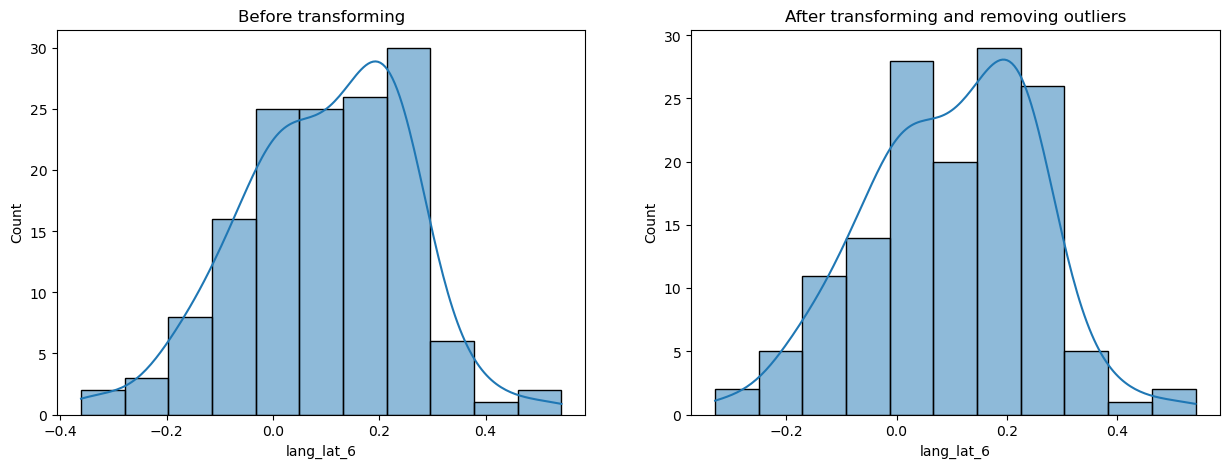

In [152]:
# Handle outliers

lat_df_ifg_6=plot_and_remove_outliers(lat_df_ifg_6, "lang_lat_6", z_threshold=3, transform=False)

#### **Measure #7**: Frontal high alpha power PSD at 6 months

In [153]:
front_alpha_power_6=frontal_power_6[["subject","high_alpha_multitaper"]]
front_alpha_power_6.rename(columns={"high_alpha_multitaper":"front_alpha_6"}, inplace=True)
front_alpha_power_6

C:\Users\gabot\AppData\Local\Temp\ipykernel_18548\545107257.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  front_alpha_power_6.rename(columns={"high_alpha_multitaper":"front_alpha_6"}, inplace=True)


,subject,front_alpha_6
0,2,-9.559983
1,3,-9.575266
2,5,-9.989601
3,6,-9.709346
4,8,-9.552358
...,...,...
115,747,-9.441419
116,748,-9.499294
117,915,-9.384641
118,933,-9.582883


Shapiro normality test before:  ShapiroResult(statistic=0.9884701371192932, pvalue=0.40796467661857605)
Number of participants before: 120
Number of participants before: 118


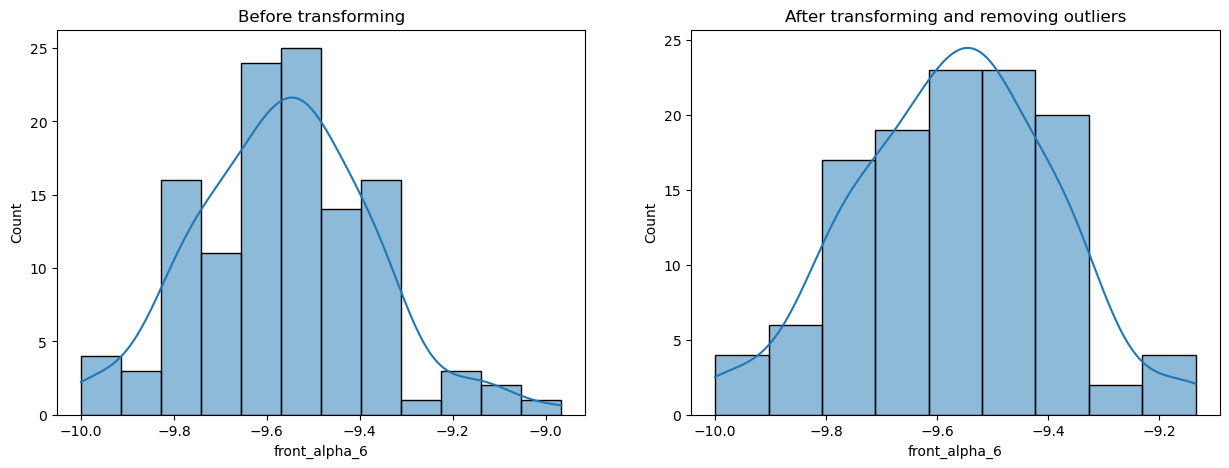

In [154]:
# Handle outliers

front_alpha_power_6=plot_and_remove_outliers(front_alpha_power_6, "front_alpha_6", z_threshold=3)

#### **Measure #8**: Gamma lateralization of the STG at 6 months

In [155]:
#### Measure #11: Gamma lateralization of the auditory cortex at 6 months
lat_df_aud=lat_df_region.loc[(lat_df_region.network=="auditory") & (lat_df_region.age == 6)]
lat_df_aud.rename(columns={"l_index":"stg_lat_6"}, inplace=True)
lat_df_aud=lat_df_aud[["subject","stg_lat_6"]]
lat_df_aud



C:\Users\gabot\AppData\Local\Temp\ipykernel_18548\1024516362.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  lat_df_aud.rename(columns={"l_index":"stg_lat_6"}, inplace=True)


,subject,stg_lat_6
9,2,0.398769
27,3,0.170415
42,5,0.059620
57,6,-0.462966
75,8,-0.022639
...,...,...
2076,747,0.462508
2088,748,0.019180
2109,915,0.377198
2121,933,-0.237448


Shapiro normality test before:  ShapiroResult(statistic=0.9928042888641357, pvalue=0.6846949458122253)
Number of participants before: 144
Number of participants before: 144


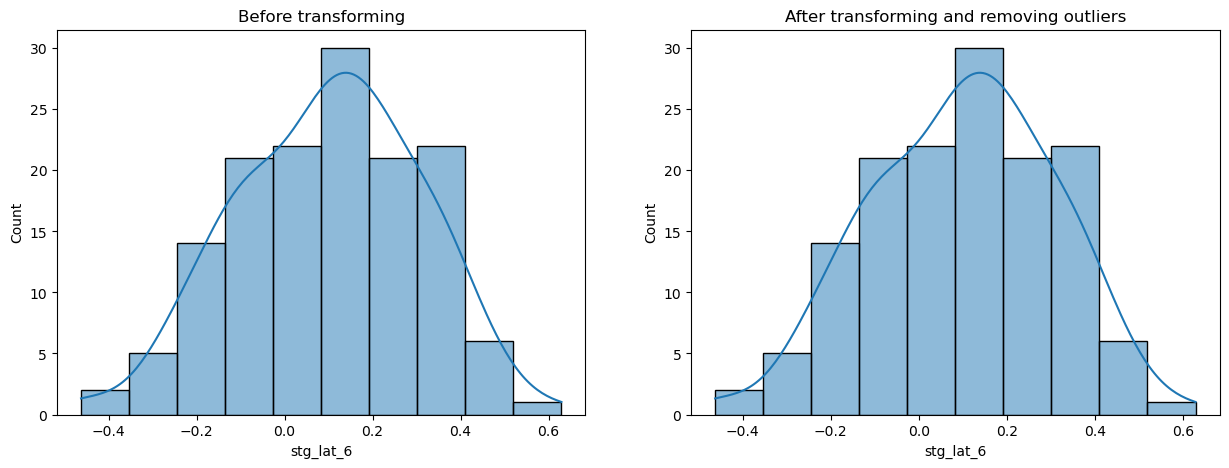

In [156]:
# Handle outliers

lat_df_aud=plot_and_remove_outliers(lat_df_aud, "stg_lat_6", z_threshold=3)

### Create exploratory dataset

In [157]:
#Define the dataframes to be merged
dataframes = [ 
    
    
    # Removed for being too close: ratio of long short, language lat, lang_con_left
    
     final_df,  # connectivity measures
     front_alpha_power_6, # literature driven 1
     lat_df_ifg_6 , # literature driven 2
        lat_df_aud, # literature driven 3
        
              frontal_power_6_sources ,# literature driven 1
              lat_df_gamma_6,  # literature driven 2             
 asd_df] # behaviour 

# Merge the dataframes based on the "subject" column
exploratory_dataset_df = reduce(lambda left, right: pd.merge(left, right, on='subject', how='outer'), dataframes)


In [158]:
exploratory_dataset_df

,subject,auditory_con_6,lang_comp_con_6,speech_con_6_left,front_alpha_6,lang_lat_6,stg_lat_6,front_gamma_6,gamma_lat_6,site,group_type,outcome,sex
0,2,-1.598480,-1.161137,-1.225266,-9.559983,0.228183,0.398769,-21.420116,NaN,washington,ELA,no-asd,M
1,3,-1.829292,-1.516043,-1.659758,-9.575266,0.111184,0.170415,-21.072590,0.040530,washington,ELA,no-asd,M
2,5,-1.823852,-1.619339,-1.464546,-9.989601,-0.002157,0.059620,-22.141673,-0.016544,washington,TLA,NaN,M
3,6,-1.429544,-1.602488,-1.757113,-9.709346,-0.201453,-0.462966,-21.630370,-0.164802,washington,ELA,no-asd,M
4,8,-1.765373,-1.587519,-1.432471,-9.552358,0.097095,-0.022639,-21.588120,-0.108383,washington,ELA,asd,M
...,...,...,...,...,...,...,...,...,...,...,...,...,...
187,9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,washington,ELA,no-asd,M
188,28,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,washington,TLA,NaN,F
189,116,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,washington,ELA,NaN,F
190,139,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,washington,ELA,NaN,F


In [159]:
# Drop all rows where there is missing EEG data
print("Shape before dropping with missing EEG:", exploratory_dataset_df.shape)
# drop all rows with NA's except for these variables 'site', 'group_type', 'outcome' and 'sex'
columns_to_check = exploratory_dataset_df.columns.difference(['site', 'group_type' , 'outcome', 'sex', 'subject'])

print("Shape after dropping with missing EEG :", exploratory_dataset_df.dropna(subset=columns_to_check, how="any").shape)


Shape before dropping with missing EEG: (192, 13)
Shape after dropping with missing EEG : (103, 13)


In [160]:
exploratory_dataset_df.to_csv(f"../../Datasets/eeg/clustering/exploratory/exploratory_driven_language_eeg_df_{date}.csv", index=False)

In [161]:
exploratory_dataset_df

,subject,auditory_con_6,lang_comp_con_6,speech_con_6_left,front_alpha_6,lang_lat_6,stg_lat_6,front_gamma_6,gamma_lat_6,site,group_type,outcome,sex
0,2,-1.598480,-1.161137,-1.225266,-9.559983,0.228183,0.398769,-21.420116,NaN,washington,ELA,no-asd,M
1,3,-1.829292,-1.516043,-1.659758,-9.575266,0.111184,0.170415,-21.072590,0.040530,washington,ELA,no-asd,M
2,5,-1.823852,-1.619339,-1.464546,-9.989601,-0.002157,0.059620,-22.141673,-0.016544,washington,TLA,NaN,M
3,6,-1.429544,-1.602488,-1.757113,-9.709346,-0.201453,-0.462966,-21.630370,-0.164802,washington,ELA,no-asd,M
4,8,-1.765373,-1.587519,-1.432471,-9.552358,0.097095,-0.022639,-21.588120,-0.108383,washington,ELA,asd,M
...,...,...,...,...,...,...,...,...,...,...,...,...,...
187,9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,washington,ELA,no-asd,M
188,28,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,washington,TLA,NaN,F
189,116,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,washington,ELA,NaN,F
190,139,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,washington,ELA,NaN,F
